<a href="https://colab.research.google.com/github/AJ-Horch/NYC_rats/blob/main/rats_in_nyc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries
I'll be using requests library to extract the data from the url and pandas to much the wrangling of the data.

In [1]:
import os
import requests
import glob

import pandas as pd
import geopandas as gpd
import numpy as np
from math import pi
import seaborn as sns
import matplotlib.pyplot as plt


### Getting the data.
Using the data provided by NYC Open Data.

In [2]:
data_url = "https://nycopendata.socrata.com/api/views/3q43-55fe/rows.csv?accessType=DOWNLOAD"

def download_data(url, path="data", name="Rat_Sightings.csv"):

    if not os.path.exists(path):
        os.mkdir(path)

    response=requests.get(url)

    with open(os.path.join(path, name), "wb") as f:
        f.write(response.content)

download_data(url=data_url, name="Rat_Sightings.csv")
os.listdir("./data/")

['Rat_Sightings.csv']

In [3]:
# code for rat inspection p937-wjvj
data_url = "https://nycopendata.socrata.com/api/views/p937-wjvj/rows.csv?accessType=DOWNLOAD"
# I can just make up a name for the csv?
def download_data(url, path="data", name="Rat_inspection.csv"):

    if not os.path.exists(path):
        os.mkdir(path)

    response=requests.get(url)

    with open(os.path.join(path, name), "wb") as f:
        f.write(response.content)

download_data(url=data_url, name="Rat_inspection.csv")
os.listdir("./data/")

['Rat_inspection.csv', 'Rat_Sightings.csv']

In [4]:
# read in rat sightings data
df = pd.read_csv("./data/Rat_Sightings.csv")
print(f'rats df shape: {df.shape}')
print(df.info())
df.head(1)

<ipython-input-4-355e614e4684>:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/Rat_Sightings.csv")


rats df shape: (240371, 38)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240371 entries, 0 to 240370
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unique Key                      240371 non-null  int64  
 1   Created Date                    240371 non-null  object 
 2   Closed Date                     223055 non-null  object 
 3   Agency                          240371 non-null  object 
 4   Agency Name                     240371 non-null  object 
 5   Complaint Type                  240371 non-null  object 
 6   Descriptor                      240371 non-null  object 
 7   Location Type                   240359 non-null  object 
 8   Incident Zip                    239938 non-null  float64
 9   Incident Address                229438 non-null  object 
 10  Street Name                     229437 non-null  object 
 11  Cross Street 1                  213983 non-null  o

Unique Key            Created Date             Closed Date Agency  \
0    43601221  08/21/2019 03:19:40 PM  09/05/2019 12:13:56 PM  DOHMH   

                               Agency Name Complaint Type    Descriptor  \
0  Department of Health and Mental Hygiene         Rodent  Rat Sighting   

         Location Type  Incident Zip Incident Address  ... Vehicle Type  \
0  1-2 Family Dwelling       11379.0   66-08 73 PLACE  ...          NaN   

  Taxi Company Borough Taxi Pick Up Location Bridge Highway Name  \
0                  NaN                   NaN                 NaN   

  Bridge Highway Direction Road Ramp Bridge Highway Segment   Latitude  \
0                      NaN       NaN                    NaN  40.714803   

   Longitude                                Location  
0 -73.880961  (40.7148032048583, -73.88096061491734)  

[1 rows x 38 columns]

In [5]:
# Dropping emtpy cols.
df = df.drop(columns=['Facility Type','Vehicle Type', 'Taxi Company Borough',
              'Taxi Pick Up Location', 'Bridge Highway Name', 'Bridge Highway Direction',
              'Road Ramp', 'Bridge Highway Segment'])

#### Rat inspection data

In [6]:
# read in rat sightings data
inspectiondf = pd.read_csv("./data/Rat_inspection.csv")
print(f'rat inspection shape: {inspectiondf.shape}')
print(inspectiondf.info())
inspectiondf.head(1)

rat inspection shape: (2526627, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526627 entries, 0 to 2526626
Data columns (total 25 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   INSPECTION_TYPE              object 
 1   JOB_TICKET_OR_WORK_ORDER_ID  int64  
 2   JOB_ID                       object 
 3   JOB_PROGRESS                 int64  
 4   BBL                          float64
 5   BORO_CODE                    int64  
 6   BLOCK                        int64  
 7   LOT                          int64  
 8   HOUSE_NUMBER                 object 
 9   STREET_NAME                  object 
 10  ZIP_CODE                     float64
 11  X_COORD                      float64
 12  Y_COORD                      float64
 13  LATITUDE                     float64
 14  LONGITUDE                    float64
 15  BOROUGH                      object 
 16  INSPECTION_DATE              object 
 17  RESULT                       object 
 18  APPROV

INSPECTION_TYPE  JOB_TICKET_OR_WORK_ORDER_ID     JOB_ID  JOB_PROGRESS  BBL  \
0         Initial                     13661515  PC8122655             1  NaN   

   BORO_CODE  BLOCK  LOT HOUSE_NUMBER STREET_NAME  ...    BOROUGH  \
0          1    529    9          NaN         NaN  ...  Manhattan   

          INSPECTION_DATE  RESULT           APPROVED_DATE  LOCATION  \
0  06/07/2023 04:36:13 PM  Passed  06/08/2023 10:38:30 AM       NaN   

  COMMUNITY BOARD COUNCIL DISTRICT CENSUS TRACT BIN  NTA  
0             NaN              NaN          NaN NaN  NaN  

[1 rows x 25 columns]

Use: zip_code, inspection_type, job_progress, location, borough, inspectation_date, result, community board. These should all be enought for now.

## Data Wrangling
Last time I used community boards to join tables. This time I'll use zip codes.

In [7]:
# looks for only finite values of zip code
rat_df = df[np.isfinite(df["Incident Zip"])]

# Columns needed for analysis
rat_df = rat_df[["Unique Key", "Created Date", "Incident Zip","Location Type", "Community Board", "Location"]]
rat_df.head(1)

Unique Key            Created Date  Incident Zip        Location Type  \
0    43601221  08/21/2019 03:19:40 PM       11379.0  1-2 Family Dwelling   

  Community Board                                Location  
0       05 QUEENS  (40.7148032048583, -73.88096061491734)

In [8]:
# Don't need the Zip being a float, a string is fine
# Going to use the str.split() funct to remove decimals and reassign
# back to the column
rat_df["Incident Zip"] = rat_df["Incident Zip"].astype('str', copy=False)

# function to remove decimal
def remove_dec(row):
    return str(row).split(".")[0]

rat_df["Incident Zip"] = rat_df["Incident Zip"].map(remove_dec)
rat_df["Incident Zip"].head()

0    11379
1    11232
2    11214
3    10037
4    11379
Name: Incident Zip, dtype: object

In [9]:
# Changing the columns to lower case
rat_df.columns = rat_df.columns.str.lower()
rat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239938 entries, 0 to 240370
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   unique key       239938 non-null  int64 
 1   created date     239938 non-null  object
 2   incident zip     239938 non-null  object
 3   location type    239926 non-null  object
 4   community board  239936 non-null  object
 5   location         238048 non-null  object
dtypes: int64(1), object(5)
memory usage: 12.8+ MB


In [10]:
# make created date a datettime
rat_df['created date'] = pd.to_datetime(rat_df['created date'], format='%m/%d/%Y %H:%M:%S %p')
rat_df.head(1)

unique key        created date incident zip        location type  \
0    43601221 2019-08-21 03:19:40        11379  1-2 Family Dwelling   

  community board                                location  
0       05 QUEENS  (40.7148032048583, -73.88096061491734)

In [11]:
# create new month col
rat_df['month'] = rat_df['created date'].dt.to_period('M')
rat_df.sample(1)

unique key        created date incident zip            location type  \
68035    53687315 2022-03-18 10:43:19        10025  3+ Family Apt. Building   

      community board                                  location    month  
68035    07 MANHATTAN  (40.792411034433236, -73.97052327889757)  2022-03

In [12]:
rat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239938 entries, 0 to 240370
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unique key       239938 non-null  int64         
 1   created date     239938 non-null  datetime64[ns]
 2   incident zip     239938 non-null  object        
 3   location type    239926 non-null  object        
 4   community board  239936 non-null  object        
 5   location         238048 non-null  object        
 6   month            239938 non-null  period[M]     
dtypes: datetime64[ns](1), int64(1), object(4), period[M](1)
memory usage: 14.6+ MB


In [13]:
# Change the community board to title
rat_df['community board'] = rat_df['community board'].str.title()
rat_df.sample()

unique key        created date incident zip          location type  \
41190    52603712 2021-11-23 12:32:51        10030  Other (Explain Below)   

      community board                                 location    month  
41190    10 Manhattan  (40.82079943512534, -73.94112979496708)  2021-11

Zip codes really take on a more categorical role in our society than a numerical role. My zip code + your zip code = Maybe a zip code in a very different place.

In [14]:
# rename the col
rat_df.rename(columns = {"incident zip":"postalcode"}, inplace=True)
# all the columns in the dataset are string
for col in rat_df.columns:
  if col != "postalcode":
    rat_df[col] = rat_df[col].astype("str", copy=False)
  else:
    # change it to int
    rat_df["postalcode"] = rat_df["postalcode"].astype("int64", copy=False)

rat_df = rat_df.sort_values("postalcode")
rat_df.head()

unique key         created date  postalcode          location type  \
203500   36827698  2017-07-30 12:00:00          83  Other (Explain Below)   
158189   29057903  2014-10-12 12:00:00          83  Other (Explain Below)   
188419   34335842  2016-09-16 12:00:00          83  Other (Explain Below)   
188195   34337516  2016-09-16 12:00:00          83  Other (Explain Below)   
205645   36946364  2017-08-14 12:00:00          83  Other (Explain Below)   

              community board                                  location  \
203500  Unspecified Manhattan  (40.782272106294286, -73.97097190908056)   
158189  Unspecified Manhattan   (40.765684114893894, -73.9762353119456)   
188419  Unspecified Manhattan    (40.7974659648698, -73.95170030179558)   
188195  Unspecified Manhattan    (40.7974659648698, -73.95170030179558)   
205645  Unspecified Manhattan   (40.78401193763258, -73.96968924461568)   

          month  
203500  2017-07  
158189  2014-10  
188419  2016-09  
188195  2016-09  
205645  2017-08

In [15]:
## sorted dates
from datetime import datetime

# Assuming rat_df is your DataFrame
sorted_dates = rat_df['created date'].sort_values(ascending=True)

sorted_dates.head()

105954    2010-01-01 02:15:27
105926    2010-01-01 03:05:37
105979    2010-01-01 04:14:27
106192    2010-01-01 08:29:58
106117    2010-01-01 08:52:19
Name: created date, dtype: object

### 83
Turns out 83 this the unoffical zip of Central Park. I'm to change the location type to central park. It's worth noting the location coordinates differ, even though they are all in central park.

In [16]:
rat_df.loc[rat_df['postalcode'] == 83, 'location type'] = 'Central Park'
rat_df.head(1)

unique key         created date  postalcode location type  \
203500   36827698  2017-07-30 12:00:00          83  Central Park   

              community board                                  location  \
203500  Unspecified Manhattan  (40.782272106294286, -73.97097190908056)   

          month  
203500  2017-07

### What is in the location types

In [17]:
location_types = rat_df['location type'].value_counts()
print(location_types)

location type
3+ Family Apt. Building          99882
1-2 Family Dwelling              44903
Other (Explain Below)            37260
3+ Family Mixed Use Building     15673
Commercial Building              13298
Vacant Lot                        6299
Construction Site                 5368
1-2 Family Mixed Use Building     3928
Vacant Building                   3813
Parking Lot/Garage                2533
Catch Basin/Sewer                 2269
Public Garden                      994
3+ Family Apartment Building       658
Government Building                502
Street Area                        434
School/Pre-School                  410
Single Room Occupancy (SRO)        269
Day Care/Nursery                   244
Office Building                    225
Residential Building               215
Public Stairs                      197
Hospital                           156
Apartment                           82
Other                               76
Residence                           72
Central Par

Some of these should be combined

In [18]:
# Unique values per community board
community_boards = rat_df['community board'].value_counts()
print(community_boards.tail(15))

community board
10 Bronx                     1138
14 Queens                     948
Unspecified Staten Island     861
11 Queens                     687
55 Brooklyn                    17
64 Manhattan                   16
0 Unspecified                  10
81 Queens                       6
83 Queens                       5
28 Bronx                        4
27 Bronx                        3
26 Bronx                        3
84 Queens                       3
nan                             2
95 Staten Island                2
Name: count, dtype: int64


Some of these community boards aren't real and will have to be removed

In [19]:
# start my droping anything that contains Unspecified
# create a boolean mask to identify rows where a col contains 'Unspecified'
# add all the wrong numbers
mask = rat_df['community board'].str.contains('Unspecified|95|84|27|26|28|81|55|64|81|nan')
# Drop rows where the column contains 'Unspecified'
rat_df = rat_df[~mask]


## Rat Inspection data wrangling
Cleaning up the inspection dataset

inspection

cols to use: inspection_type, zip_code, inspection_type, job_progress, location, borough, inspectation_date, result, community board.

https://data.cityofnewyork.us/Health/Rodent-Inspection/p937-wjvj/about_data


In [20]:
# Changing the columns to lower case
inspectiondf.columns = inspectiondf.columns.str.lower()


In [21]:
inspectiondf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526627 entries, 0 to 2526626
Data columns (total 25 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   inspection_type              object 
 1   job_ticket_or_work_order_id  int64  
 2   job_id                       object 
 3   job_progress                 int64  
 4   bbl                          float64
 5   boro_code                    int64  
 6   block                        int64  
 7   lot                          int64  
 8   house_number                 object 
 9   street_name                  object 
 10  zip_code                     float64
 11  x_coord                      float64
 12  y_coord                      float64
 13  latitude                     float64
 14  longitude                    float64
 15  borough                      object 
 16  inspection_date              object 
 17  result                       object 
 18  approved_date                object 
 19  

In [22]:
# looks for only finite values of zip code
inspections = inspectiondf[np.isfinite(inspectiondf["zip_code"])]

# Columns needed for analysis
inspections = inspections[['inspection_date','inspection_type',
 'result','zip_code', 'borough','community board','location']]
inspections.head(1)

inspection_date inspection_type  result  zip_code    borough  \
0  06/07/2023 04:36:13 PM         Initial  Passed       0.0  Manhattan   

   community board location  
0              NaN      NaN

In [23]:
# Don't need the Zip being a float, a string is fine
# Going to use the str.split() funct to remove decimals and reassign
# back to the column
inspections["zip_code"] = inspections["zip_code"].astype('str', copy=False)

# function to remove decimal
def remove_dec(row):
    return str(row).split(".")[0]

inspections["zip_code"] = inspections["zip_code"].map(remove_dec)
inspections["zip_code"].head(3)


0        0
3    10451
7    11216
Name: zip_code, dtype: object

In [24]:
# change the community board from float to str
# Going to use the str.split() funct to remove decimals and reassign
# back to the column
inspections["community board"] = inspections["community board"].astype('str', copy=False)

# function to remove decimal
def remove_dec(row):
    return str(row).split(".")[0]

inspections["community board"] = inspections["community board"].map(remove_dec)
inspections["community board"].head(3)

0    nan
3    nan
7    nan
Name: community board, dtype: object

In [25]:
# Find out the dates in the dataset
# use inspection_date
min_sorted_dates = inspections['inspection_date'].sort_values(ascending=True)
max_sorted_dates = inspections['inspection_date'].sort_values(ascending=False)
print(f'starting date {min_sorted_dates.head(1)}')
print(f'ending date {max_sorted_dates.head(1)}')

starting date 794551    01/01/2001 03:15:00 PM
Name: inspection_date, dtype: object
ending date 417013    12/31/2023 09:35:32 AM
Name: inspection_date, dtype: object


Ends in 21/31/23 So I may need to adjust the other datasets to only include dates up to the end of 2023

In [26]:
# make created date a datettime
inspections['inspection_date'] = pd.to_datetime(inspections['inspection_date'], format='%m/%d/%Y %H:%M:%S %p')
inspections.head(1)

inspection_date inspection_type  result zip_code    borough  \
0 2023-06-07 04:36:13         Initial  Passed        0  Manhattan   

  community board location  
0             nan      NaN

In [27]:
# create new month col
inspections['month'] = inspections['inspection_date'].dt.to_period('M')
inspections.sample(1)

inspection_date inspection_type  result zip_code    borough  \
1574485 2010-03-09 12:31:50         Initial  Passed    10011  Manhattan   

        community board                             location    month  
1574485               4  (40.742277927257, -74.006416368768)  2010-03

In [28]:
# filter so only data after 2010 is used
inspections = inspections[inspections['month'] >= '2009/01']
inspections.head(1)

inspection_date inspection_type  result zip_code    borough  \
0 2023-06-07 04:36:13         Initial  Passed        0  Manhattan   

  community board location    month  
0             nan      NaN  2023-06

In [29]:
inspections.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2511198 entries, 0 to 2526626
Data columns (total 8 columns):
 #   Column           Dtype         
---  ------           -----         
 0   inspection_date  datetime64[ns]
 1   inspection_type  object        
 2   result           object        
 3   zip_code         object        
 4   borough          object        
 5   community board  object        
 6   location         object        
 7   month            period[M]     
dtypes: datetime64[ns](1), object(6), period[M](1)
memory usage: 172.4+ MB


In [30]:
# rename the community board to cb_id
inspections = inspections.rename(columns={'community board':'cb_id'})

In [31]:
# check cb_ids for anything that doesn't belong
print(inspections['cb_id'].value_counts())

cb_id
3      415624
4      350729
7      218176
5      208912
6      167333
8      165220
9      160518
2      151429
1      145980
12     140704
10     134997
11     112250
nan     56277
13      18890
16      16512
14      16297
17      15448
18       8943
15       6756
27         69
26         49
64         32
55         22
95         16
84          7
28          4
80          1
83          1
81          1
56          1
Name: count, dtype: int64


In [32]:
# start by droping anything that contains nonactual cb_ids
# create a boolean mask to identify rows where a col contains 'Unspecified'
# add all the wrong numbers
mask = inspections['cb_id'].str.contains('27|26|64|55|95|84|28|56|81|80|83|nan')
# Drop rows where the column contains the numbers above
inspections = inspections[~mask]

In [33]:
inspections['community board'] = inspections['cb_id'].str.cat(inspections['borough'], sep=' ')
inspections.head(2)

inspection_date inspection_type        result zip_code borough cb_id  \
68 2021-11-04 10:16:28            BAIT  Bait applied    11237     NaN     4   
88 2010-04-07 04:10:28         Initial        Passed    11421  Queens     9   

   location    month community board  
68      NaN  2021-11             NaN  
88      NaN  2010-04        9 Queens

In [34]:
inspections['community board'].value_counts()

community board
3 Brooklyn          203308
4 Brooklyn          156950
3 Manhattan         128365
4 Bronx             120762
6 Bronx             113622
5 Bronx             108269
10 Manhattan        100744
7 Bronx              99550
7 Manhattan          98922
8 Manhattan          79639
12 Manhattan         73531
11 Manhattan         72796
2 Manhattan          69564
8 Brooklyn           60938
9 Manhattan          56865
9 Bronx              56707
4 Manhattan          48390
3 Bronx              45986
5 Queens             43807
5 Brooklyn           41788
9 Brooklyn           40346
1 Brooklyn           38440
1 Staten Island      33794
1 Bronx              32312
11 Bronx             30589
2 Bronx              30234
12 Queens            30021
12 Bronx             29566
6 Manhattan          28847
3 Queens             27831
2 Brooklyn           27604
4 Queens             24572
1 Queens             23508
10 Bronx             21119
6 Brooklyn           20549
8 Bronx              18970
1 Manhattan 

In [35]:
inspections['inspection_type'].value_counts()

inspection_type
Initial       1739151
Compliance     371947
BAIT           343620
Name: count, dtype: int64

In [36]:
inspections['result'].value_counts()

result
Passed                1496473
Rat Activity           397812
Bait applied           343430
Failed for Other R     216777
Monitoring visit          190
Name: count, dtype: int64

It could be intersting to spilt up this inspection_types and results. Maybe make it granular where I only use results that have rat activity or bait applied, or even failed...

Perhaps I should just drop the Passed because it's unclear what that means. My assumption is that it means there is no activity and therefore no rats.

On second thought I'm not going to remove 'Passed'. I think 'Passed' could be useful for some ML/Deep Learning work. Passed represents properties that have no signs of rats. This feature could be used to tell an algo that rats are less likely in a certain area, etc. I'll maybe two new columns. Boolean 0 for passed and 1 for rat activity which will encompass the others

From NYC: Result of the inspection, including: Active Rat Signs (ARS) - ARS include any of six different signs: 1) fresh tracks, 2) fresh droppings, 3) active burrows, 4) active runways and rub marks, 5) fresh gnawing marks, and 6) live rats. Problem Conditions - Problem conditions include garbage (poor containerization of food waste resulting in the feeding of rats), harborage (clutter and dense vegetation promoting the nesting of rats), and mice.

"In conjunction with the JOBTICKETORWORKORDERID, uniquely identifies records in the dataset. Initial Inspection - Inspection conducted in response to a 311 complaint, or a proactive inspection conducted through our neighborhood indexing program. Compliance Inspection - If a property fails its initial inspection, the Health Department will conduct a follow up (Compliance) inspection. Baiting - Application of rodenticide, or monitoring visit by a Health Department Pest Control Professional. Clean Up - The removal of garbage and clutter from a property by the Health Department. Initial Inspection - Inspection conducted in response to a 311 complaint, or a proactive inspection conducted through our neighborhood indexing program. Compliance Inspection - If a property fails its initial inspection, the Health Department will conduct a follow up (Compliance) inspection. Baiting - Application of rodenticide, or monitoring visit by a Health Department Pest Control Professional. Clean Up - The removal of garbage and clutter from a property by the Health Department.

Based on this I'm also going to create another column called repeat_offender. For If there is a compliance in inspection type the column will have a 1. This column will represent locations where rat activty presists.

In [37]:
# Create new columns
inspections['no_activity'] = inspections['result'].apply(lambda x: 1 if x== 'Passed' else 0)

inspections['activity'] = inspections['result'].apply(lambda x: 0 if x== 'Passed' else 1)
inspections.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2454718 entries, 68 to 2526626
Data columns (total 11 columns):
 #   Column           Dtype         
---  ------           -----         
 0   inspection_date  datetime64[ns]
 1   inspection_type  object        
 2   result           object        
 3   zip_code         object        
 4   borough          object        
 5   cb_id            object        
 6   location         object        
 7   month            period[M]     
 8   community board  object        
 9   no_activity      int64         
 10  activity         int64         
dtypes: datetime64[ns](1), int64(2), object(7), period[M](1)
memory usage: 224.7+ MB


In [38]:
# create repeat_offence column
inspections['repeat_offence'] = (inspections['inspection_type'] =='Compliance') & (inspections['result'] != 'Passed')
inspections['repeat_offence'] = inspections['repeat_offence'].astype(int)

In [39]:
inspections.head(10)

inspection_date inspection_type        result zip_code    borough  \
68  2021-11-04 10:16:28            BAIT  Bait applied    11237        NaN   
88  2010-04-07 04:10:28         Initial        Passed    11421     Queens   
279 2023-01-27 01:10:00            BAIT  Bait applied    10026        NaN   
284 2023-06-05 03:19:22         Initial        Passed    11377     Queens   
297 2016-10-04 02:02:02         Initial        Passed    11103     Queens   
300 2024-02-12 03:10:16         Initial  Rat Activity    11417     Queens   
346 2022-02-28 04:00:00         Initial        Passed    11222   Brooklyn   
376 2022-06-21 08:35:00      Compliance        Passed    11105     Queens   
436 2016-11-29 04:07:06         Initial        Passed    10457      Bronx   
438 2022-07-21 12:56:32         Initial  Rat Activity    10009  Manhattan   

    cb_id                             location    month community board  \
68      4                                  NaN  2021-11             NaN   
88      9                                  NaN  2010-04        9 Queens   
279    10                                  NaN  2023-01             NaN   
284     2                                  NaN  2023-06        2 Queens   
297     1  (40.756447260573, -73.917724430674)  2016-10        1 Queens   
300    10  (40.682145153027, -73.838985952238)  2024-02       10 Queens   
346     1                                  NaN  2022-02      1 Brooklyn   
376     1                                  NaN  2022-06        1 Queens   
436     6  (40.845930919837, -73.896555813219)  2016-11         6 Bronx   
438     3                                  NaN  2022-07     3 Manhattan   

     no_activity  activity  repeat_offence  
68             0         1               0  
88             1         0               0  
279            0         1               0  
284            1         0               0  
297            1         0               0  
300            0         1               0  
346            1         0               0  
376            1         0               0  
436            1         0               0  
438            0         1               0

In [40]:
# rename zip code for merge later
inspections.rename(columns = {"zip_code":"postalcode"}, inplace=True)
inspections.head(1)

inspection_date inspection_type        result postalcode borough cb_id  \
68 2021-11-04 10:16:28            BAIT  Bait applied      11237     NaN     4   

   location    month community board  no_activity  activity  repeat_offence  
68      NaN  2021-11             NaN            0         1               0

In [41]:
# check for nan
nan_values = inspections.isna().sum()
print(nan_values)

inspection_date       0
inspection_type       0
result               36
postalcode            0
borough             212
cb_id                 0
location           1471
month                 0
community board     212
no_activity           0
activity              0
repeat_offence        0
dtype: int64


In [42]:
# Dropping all the nan's will have minial impact
inspections.dropna(inplace=True)

### Tonnage data


In [43]:
data_url = "https://nycopendata.socrata.com/api/views/ebb7-mvp5/rows.csv?accessType=DOWNLOAD"
def download_data(url, path="data", name="DSNY_Tonage.csv"):

    if not os.path.exists(path):
        os.mkdir(path)

    response=requests.get(url)

    with open(os.path.join(path, name), "wb") as f:
        f.write(response.content)

download_data(url=data_url, name="DSNY_Tonage.csv")
os.listdir("./data/")

['Rat_inspection.csv', 'DSNY_Tonage.csv', 'Rat_Sightings.csv']

In [44]:
tonnage= pd.read_csv("./data/DSNY_Tonage.csv")
#print(df.shape)
#print(df.info())
tonnage.tail(10)

MONTH    BOROUGH COMMUNITYDISTRICT  REFUSETONSCOLLECTED  \
23581  2024 / 03      Bronx                11               2959.9   
23582  2024 / 04   Brooklyn                02                707.4   
23583  2024 / 04      Bronx                06                587.1   
23584  2024 / 04  Manhattan                08               1124.4   
23585  2024 / 04     Queens                07               1754.2   
23586  2024 / 02   Brooklyn                17               3650.1   
23587  2024 / 01   Brooklyn                13               2043.7   
23588  2024 / 04     Queens                04               1113.1   
23589  2024 / 03  Manhattan                09               2011.3   
23590  2024 / 04     Queens                08                878.5   

       PAPERTONSCOLLECTED  MGPTONSCOLLECTED  RESORGANICSTONS  \
23581               269.1             296.0              NaN   
23582               126.9             100.4             17.4   
23583                33.8              42.6              NaN   
23584               226.1             160.7              NaN   
23585               170.6             186.7             22.2   
23586               254.3             357.1             40.6   
23587               180.4             228.8             16.4   
23588                73.0             127.9              5.8   
23589               230.9             240.1              NaN   
23590               109.8              94.9             13.2   

       SCHOOLORGANICTONS  LEAVESORGANICTONS  XMASTREETONS  BOROUGH_ID  
23581                NaN                NaN           NaN         2.0  
23582                8.0                NaN           NaN         3.0  
23583                9.9                NaN           NaN         2.0  
23584                NaN                NaN           NaN         1.0  
23585               35.1                NaN           NaN         4.0  
23586                NaN                NaN           NaN         3.0  
23587                NaN                NaN           NaN         3.0  
23588                NaN                NaN           NaN         4.0  
23589               89.9                NaN           NaN         1.0  
23590                NaN                NaN           NaN         4.0

### Population
Not sure these are needed




In [45]:
!pip install sodapy
from sodapy import Socrata


In [46]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  username="josephhorch@gmail.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("xi7c-iiu2", limit=2000)

# Convert to pandas DataFrame
population = pd.DataFrame.from_records(results)

In [47]:
population.head()

borough cd_number                             cd_name _1970_population  \
0   Bronx         1    Melrose, Mott Haven, Port Morris           138557   
1   Bronx         2               Hunts Point, Longwood            99493   
2   Bronx         3       Morrisania, Crotona Park East           150636   
3   Bronx         4       Highbridge, Concourse Village           144207   
4   Bronx         5  University Hts., Fordham, Mt. Hope           121807   

  _1980_population _1990_population _2000_population _2010_population  
0            78441            77214            82159            91497  
1            34399            39443            46824            52246  
2            53635            57162            68574            79762  
3           114312           119962           139563           146441  
4           107995           118435           128313           128200

### Cleaning tonnage

rat_df starts at: 01/01/2010, So I need to drop all the tonnage up until then

In [48]:
tonnage.columns = tonnage.columns.str.lower()
tonnage.head(1)

month    borough communitydistrict  refusetonscollected  \
0  1990 / 08  Manhattan                03               3258.3   

   papertonscollected  mgptonscollected  resorganicstons  schoolorganictons  \
0                 NaN               NaN              NaN                NaN   

   leavesorganictons  xmastreetons  borough_id  
0                NaN           NaN         1.0

In [49]:
tonnage = tonnage[tonnage['month'] >= '2009/01']
tonnage.head(1)

month borough communitydistrict  refusetonscollected  \
1711  2010 / 01  Queens                06               2569.1   

      papertonscollected  mgptonscollected  resorganicstons  \
1711               436.8             297.1              NaN   

      schoolorganictons  leavesorganictons  xmastreetons  borough_id  
1711                NaN                NaN          13.6         4.0

In [50]:
tonnage.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10154 entries, 1711 to 23590
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                10154 non-null  object 
 1   borough              10154 non-null  object 
 2   communitydistrict    10154 non-null  object 
 3   refusetonscollected  10148 non-null  float64
 4   papertonscollected   10148 non-null  float64
 5   mgptonscollected     10148 non-null  float64
 6   resorganicstons      2153 non-null   float64
 7   schoolorganictons    1705 non-null   float64
 8   leavesorganictons    349 non-null    float64
 9   xmastreetons         817 non-null    float64
 10  borough_id           10148 non-null  float64
dtypes: float64(8), object(3)
memory usage: 1.2+ MB


In [51]:
tonnage.isnull().sum()

month                     0
borough                   0
communitydistrict         0
refusetonscollected       6
papertonscollected        6
mgptonscollected          6
resorganicstons        8001
schoolorganictons      8449
leavesorganictons      9805
xmastreetons           9337
borough_id                6
dtype: int64

In [52]:
# Dropping the organic collections, too many nulls
tonnage = tonnage.drop(columns=['resorganicstons','schoolorganictons','leavesorganictons',
                                'xmastreetons'])
tonnage.head(2)

month borough communitydistrict  refusetonscollected  \
1711  2010 / 01  Queens                06               2569.1   
1712  2010 / 01   Bronx                02               1644.6   

      papertonscollected  mgptonscollected  borough_id  
1711               436.8             297.1         4.0  
1712                89.6             102.2         2.0

In [53]:
tonnage['community_district'] = tonnage['communitydistrict'].str.cat(tonnage['borough'], sep=' ')
tonnage.head(2)

month borough communitydistrict  refusetonscollected  \
1711  2010 / 01  Queens                06               2569.1   
1712  2010 / 01   Bronx                02               1644.6   

      papertonscollected  mgptonscollected  borough_id community_district  
1711               436.8             297.1         4.0          06 Queens  
1712                89.6             102.2         2.0           02 Bronx

In [54]:
# create a total collection column
tonnage['totalcollection'] = tonnage[['refusetonscollected','papertonscollected','mgptonscollected']].sum(axis=1)
tonnage.head(1)

month borough communitydistrict  refusetonscollected  \
1711  2010 / 01  Queens                06               2569.1   

      papertonscollected  mgptonscollected  borough_id community_district  \
1711               436.8             297.1         4.0          06 Queens   

      totalcollection  
1711           3303.0

### Joining Zip codes
On second thought it might be better to join on community district because those are shared. Or can I use methods from solve any data analysis to add zip codes???

I'll start by creating community districts to join on

I need a dataset with the postcodes and their neighborhoods

In [55]:
rat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210793 entries, 211754 to 16655
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   unique key       210793 non-null  object
 1   created date     210793 non-null  object
 2   postalcode       210793 non-null  int64 
 3   location type    210793 non-null  object
 4   community board  210793 non-null  object
 5   location         210793 non-null  object
 6   month            210793 non-null  object
dtypes: int64(1), object(6)
memory usage: 12.9+ MB


In [56]:
# make created date a datettime
rat_df['created date'] = pd.to_datetime(rat_df['created date'], format='ISO8601')
rat_df.head(1)

unique key        created date  postalcode location type  \
211754   37791806 2017-11-27 12:00:00          83  Central Park   

       community board                                 location    month  
211754    10 Manhattan  (40.79757295469069, -73.95157020157765)  2017-11

In [57]:
zip_codes = ['Bronx',
 ' Central Bronx',
 ' 10453, 10457, 10460',
 ' Bronx Park and Fordham',
 ' 10458, 10467, 10468',
 ' High Bridge and Morrisania',
 ' 10451, 10452, 10456',
 ' Hunts Point and Mott Haven',
 ' 10454, 10455, 10459, 10474',
 ' Kingsbridge and Riverdale',
 ' 10463, 10471',
 ' Northeast Bronx',
 ' 10466, 10469, 10470, 10475',
 ' Southeast Bronx',
 ' 10461, 10462,10464, 10465, 10472, 10473',
 'Brooklyn',
 ' Central Brooklyn',
 ' 11212, 11213, 11216, 11233, 11238',
 ' Southwest Brooklyn',
 ' 11209, 11214, 11228',
 ' Borough Park',
 ' 11204, 11218, 11219, 11230',
 ' Canarsie and Flatlands',
 ' 11234, 11236, 11239',
 ' Southern Brooklyn',
 ' 11223, 11224, 11229, 11235',
 ' Northwest Brooklyn',
 ' 11201, 11205, 11215, 11217, 11231',
 ' Flatbush',
 ' 11203, 11210, 11225, 11226',
 ' East New York and New Lots',
 ' 11207, 11208',
 ' Greenpoint',
 ' 11211, 11222',
 ' Sunset Park',
 ' 11220, 11232',
 ' Bushwick and Williamsburg',
 ' 11206, 11221, 11237',
 'Manhattan',
 ' Central Harlem',
 ' 10026, 10027, 10030, 10037, 10039',
 ' Chelsea and Clinton',
 ' 10001, 10011, 10018, 10019, 10020, 10036',
 ' East Harlem',
 ' 10029, 10035',
 ' Gramercy Park and Murray Hill',
 ' 10010, 10016, 10017, 10022',
 ' Greenwich Village and Soho',
 ' 10012, 10013, 10014',
 ' Lower Manhattan',
 ' 10004, 10005, 10006, 10007, 10038, 10280',
 ' Lower East Side',
 ' 10002, 10003, 10009',
 ' Upper East Side',
 ' 10021, 10028, 10044, 10065, 10075, 10128',
 ' Upper West Side',
 ' 10023, 10024, 10025',
 ' Inwood and Washington Heights',
 ' 10031, 10032, 10033, 10034, 10040',
 'Queens',
 ' Northeast Queens',
 ' 11361, 11362, 11363, 11364',
 ' North Queens',
 ' 11354, 11355, 11356, 11357, 11358, 11359, 11360',
 ' Central Queens',
 ' 11365, 11366, 11367',
 ' Jamaica',
 ' 11412, 11423, 11432, 11433, 11434, 11435, 11436',
 ' Northwest Queens',
 ' 11101, 11102, 11103, 11104, 11105, 11106',
 ' West Central Queens',
 ' 11374, 11375, 11379, 11385',
 ' Rockaways',
 ' 11691, 11692, 11693, 11694, 11695, 11697',
 ' Southeast Queens',
 ' 11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428, 11429',
 ' Southwest Queens',
 ' 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421',
 ' West Queens',
 ' 11368, 11369, 11370, 11372, 11373, 11377, 11378',
 'Staten Island',
 ' Port Richmond',
 ' 10302, 10303, 10310',
 ' South Shore',
 ' 10306, 10307, 10308, 10309, 10312',
 ' Stapleton and St. George',
 ' 10301, 10304, 10305',
 ' Mid-Island',
 ' 10314']

In [58]:
boroughs = ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"]

# indices to partition the data
idxs = []

#iterate through and capture the indices of each broough respectively
for borough in boroughs:
    idxs.append(zip_codes.index(borough))

# make sure that last index is captured to encapsulate all the data
idxs.append(len(zip_codes))
idxs

[0, 15, 38, 59, 80, 89]

In [59]:
# create a function to partition the data
def set_partitions (data, indices):
  """ Partition the data based on the input date list and the index list -
  return the list of paritioned data.
  """
  data_partitions = []

  i = 1
  while i <= len(indices) -1:
    data_partitions.append(data[indices[i-1]+1:indices[i]])
    i = i + 1

  return data_partitions

prt_data = set_partitions(zip_codes, idxs)
prt_data

[[' Central Bronx',
  ' 10453, 10457, 10460',
  ' Bronx Park and Fordham',
  ' 10458, 10467, 10468',
  ' High Bridge and Morrisania',
  ' 10451, 10452, 10456',
  ' Hunts Point and Mott Haven',
  ' 10454, 10455, 10459, 10474',
  ' Kingsbridge and Riverdale',
  ' 10463, 10471',
  ' Northeast Bronx',
  ' 10466, 10469, 10470, 10475',
  ' Southeast Bronx',
  ' 10461, 10462,10464, 10465, 10472, 10473'],
 [' Central Brooklyn',
  ' 11212, 11213, 11216, 11233, 11238',
  ' Southwest Brooklyn',
  ' 11209, 11214, 11228',
  ' Borough Park',
  ' 11204, 11218, 11219, 11230',
  ' Canarsie and Flatlands',
  ' 11234, 11236, 11239',
  ' Southern Brooklyn',
  ' 11223, 11224, 11229, 11235',
  ' Northwest Brooklyn',
  ' 11201, 11205, 11215, 11217, 11231',
  ' Flatbush',
  ' 11203, 11210, 11225, 11226',
  ' East New York and New Lots',
  ' 11207, 11208',
  ' Greenpoint',
  ' 11211, 11222',
  ' Sunset Park',
  ' 11220, 11232',
  ' Bushwick and Williamsburg',
  ' 11206, 11221, 11237'],
 [' Central Harlem',
  '

#### Create a sub-dictionary
d[neighborhood] = zip code

In [60]:
def get_sub_keys(data_partition):
  """ Takes in the partitioned data list. Creates a dictionary
  relating the zip code values to their corresponding neighborhoods
  """
# create empty list
  nyc_dicts = []

  for borough in data_partition:
    keys = borough[::2]
    values = borough[1::2]
    new_vals = []
    for val in values:
      new_vals.append(val.split(","))
    nyc_dicts.append(dict(zip(keys, new_vals)))

  return nyc_dicts

# return the dict
nyc_dict = get_sub_keys(prt_data)
nyc_dict

[{' Central Bronx': [' 10453', ' 10457', ' 10460'],
  ' Bronx Park and Fordham': [' 10458', ' 10467', ' 10468'],
  ' High Bridge and Morrisania': [' 10451', ' 10452', ' 10456'],
  ' Hunts Point and Mott Haven': [' 10454', ' 10455', ' 10459', ' 10474'],
  ' Kingsbridge and Riverdale': [' 10463', ' 10471'],
  ' Northeast Bronx': [' 10466', ' 10469', ' 10470', ' 10475'],
  ' Southeast Bronx': [' 10461',
   ' 10462',
   '10464',
   ' 10465',
   ' 10472',
   ' 10473']},
 {' Central Brooklyn': [' 11212', ' 11213', ' 11216', ' 11233', ' 11238'],
  ' Southwest Brooklyn': [' 11209', ' 11214', ' 11228'],
  ' Borough Park': [' 11204', ' 11218', ' 11219', ' 11230'],
  ' Canarsie and Flatlands': [' 11234', ' 11236', ' 11239'],
  ' Southern Brooklyn': [' 11223', ' 11224', ' 11229', ' 11235'],
  ' Northwest Brooklyn': [' 11201', ' 11205', ' 11215', ' 11217', ' 11231'],
  ' Flatbush': [' 11203', ' 11210', ' 11225', ' 11226'],
  ' East New York and New Lots': [' 11207', ' 11208'],
  ' Greenpoint': [' 1

Now map the neighborhoods to the boros


In [61]:
def create_dict(boroughs, sub_dict):
  """ Beinging it all back together. Taking the dictionary of the neighborhoods
  and assinging them to their corresponding borough and returning a dictionary.
  """

  d = {}

  for boro in boroughs:
    d[boro] = {}

  i = 0
  while i < len(boroughs):
    d[boroughs[i]] = sub_dict[i]
    i = i + 1

  return d

# assign to the main keys
nyc_dict = create_dict(boroughs, nyc_dict)
nyc_dict

{'Bronx': {' Central Bronx': [' 10453', ' 10457', ' 10460'],
  ' Bronx Park and Fordham': [' 10458', ' 10467', ' 10468'],
  ' High Bridge and Morrisania': [' 10451', ' 10452', ' 10456'],
  ' Hunts Point and Mott Haven': [' 10454', ' 10455', ' 10459', ' 10474'],
  ' Kingsbridge and Riverdale': [' 10463', ' 10471'],
  ' Northeast Bronx': [' 10466', ' 10469', ' 10470', ' 10475'],
  ' Southeast Bronx': [' 10461',
   ' 10462',
   '10464',
   ' 10465',
   ' 10472',
   ' 10473']},
 'Brooklyn': {' Central Brooklyn': [' 11212',
   ' 11213',
   ' 11216',
   ' 11233',
   ' 11238'],
  ' Southwest Brooklyn': [' 11209', ' 11214', ' 11228'],
  ' Borough Park': [' 11204', ' 11218', ' 11219', ' 11230'],
  ' Canarsie and Flatlands': [' 11234', ' 11236', ' 11239'],
  ' Southern Brooklyn': [' 11223', ' 11224', ' 11229', ' 11235'],
  ' Northwest Brooklyn': [' 11201', ' 11205', ' 11215', ' 11217', ' 11231'],
  ' Flatbush': [' 11203', ' 11210', ' 11225', ' 11226'],
  ' East New York and New Lots': [' 11207',

Move on to the dataframe here

In [62]:

nhooddata = {
    'borough': [],
    'neighborhood': [],
    'postalcode': []
}

boroughs = list(nyc_dict.keys())

for borough in boroughs:
    neighborhoods = list(nyc_dict[borough].keys())
    for neighborhood in neighborhoods:
        postcodes = nyc_dict[borough][neighborhood]
        for postcode in postcodes:
            nhooddata['borough'].append(borough.strip())
            nhooddata['neighborhood'].append(neighborhood.strip())
            nhooddata['postalcode'].append(postcode.strip())

nycdf = pd.DataFrame(nhooddata)
nycdf.head(10)

borough                neighborhood postalcode
0   Bronx               Central Bronx      10453
1   Bronx               Central Bronx      10457
2   Bronx               Central Bronx      10460
3   Bronx      Bronx Park and Fordham      10458
4   Bronx      Bronx Park and Fordham      10467
5   Bronx      Bronx Park and Fordham      10468
6   Bronx  High Bridge and Morrisania      10451
7   Bronx  High Bridge and Morrisania      10452
8   Bronx  High Bridge and Morrisania      10456
9   Bronx  Hunts Point and Mott Haven      10454

In [63]:
# check for any differences in dissimilar zip codes
list(set(rat_df['postalcode']).difference(set(nycdf['postalcode'])))

[10278,
 10280,
 10282,
 12345,
 10301,
 10302,
 10303,
 10304,
 10305,
 10306,
 10307,
 10308,
 10309,
 10310,
 10312,
 10314,
 83,
 11354,
 11355,
 11356,
 11357,
 11358,
 11360,
 11361,
 11362,
 11363,
 11364,
 11365,
 11366,
 11367,
 11368,
 11369,
 11370,
 11372,
 11373,
 11374,
 11375,
 11377,
 11378,
 11379,
 11385,
 11411,
 11412,
 11413,
 11414,
 11415,
 11416,
 11417,
 11418,
 11419,
 11420,
 11421,
 11422,
 11423,
 11426,
 11427,
 11428,
 11429,
 11430,
 11432,
 11433,
 11434,
 11435,
 11436,
 10451,
 10452,
 10453,
 10454,
 10455,
 10456,
 10457,
 10458,
 10459,
 10460,
 10461,
 10462,
 10463,
 10464,
 10465,
 10466,
 10467,
 10468,
 10469,
 10470,
 10471,
 10472,
 10473,
 10474,
 10475,
 11001,
 11004,
 10001,
 10002,
 10003,
 10004,
 10005,
 10006,
 10007,
 10009,
 10010,
 10011,
 10012,
 10013,
 10014,
 11040,
 10016,
 10017,
 10018,
 10019,
 10020,
 10021,
 10022,
 10023,
 10024,
 10025,
 10026,
 10027,
 10028,
 10029,
 10030,
 10031,
 10032,
 10033,
 10034,
 10035,
 10

In [64]:
print(rat_df.info())
print(nycdf.info())


<class 'pandas.core.frame.DataFrame'>
Index: 210793 entries, 211754 to 16655
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unique key       210793 non-null  object        
 1   created date     210793 non-null  datetime64[ns]
 2   postalcode       210793 non-null  int64         
 3   location type    210793 non-null  object        
 4   community board  210793 non-null  object        
 5   location         210793 non-null  object        
 6   month            210793 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 12.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   borough       178 non-null    object
 1   neighborhood  178 non-null    object
 2   postalcode    178 non-null    object
dtypes: object(3

In [65]:
nycdf["postalcode"] = nycdf["postalcode"].astype("int64", copy=False)


In [66]:
rat_df = rat_df.merge(nycdf, on="postalcode")
print(rat_df.shape)
rat_df.head(10)

(209682, 9)


unique key        created date  postalcode                 location type  \
0   52294394 2021-10-25 09:51:21       10001         Other (Explain Below)   
1   27944790 2014-04-30 12:00:00       10001       3+ Family Apt. Building   
2   19630346 2011-01-19 12:00:00       10001               Office Building   
3   20128177 2011-03-29 12:00:00       10001       3+ Family Apt. Building   
4   42236562 2019-04-16 07:30:52       10001             Construction Site   
5   43906398 2019-09-07 11:21:36       10001           Commercial Building   
6   53512139 2022-03-02 09:55:05       10001  3+ Family Mixed Use Building   
7   54785782 2022-07-14 01:08:20       10001       3+ Family Apt. Building   
8   42821486 2019-05-31 02:14:50       10001  3+ Family Mixed Use Building   
9   57735046 2023-05-28 11:07:47       10001       3+ Family Apt. Building   

  community board                                  location    month  \
0    04 Manhattan   (40.749272931504095, -73.9962501248835)  2021-10   
1    04 Manhattan   (40.75042849369146, -73.99705490743705)  2014-04   
2    04 Manhattan  (40.749638039983026, -73.99903635982373)  2011-01   
3    05 Manhattan   (40.74654990370818, -73.99171019144391)  2011-03   
4    05 Manhattan   (40.748125506226835, -73.9935325693227)  2019-04   
5    05 Manhattan   (40.74979417997734, -73.99148602057147)  2019-09   
6    04 Manhattan   (40.74923999191611, -73.99617072614878)  2022-03   
7    04 Manhattan   (40.74923999191611, -73.99617072614878)  2022-07   
8    04 Manhattan    (40.74456277751842, -73.9927858802646)  2019-05   
9    04 Manhattan   (40.74742577604953, -73.99955248159598)  2023-05   

     borough         neighborhood  
0  Manhattan  Chelsea and Clinton  
1  Manhattan  Chelsea and Clinton  
2  Manhattan  Chelsea and Clinton  
3  Manhattan  Chelsea and Clinton  
4  Manhattan  Chelsea and Clinton  
5  Manhattan  Chelsea and Clinton  
6  Manhattan  Chelsea and Clinton  
7  Manhattan  Chelsea and Clinton  
8  Manhattan  Chelsea and Clinton  
9  Manhattan  Chelsea and Clinton

In [67]:
inspections["postalcode"] = inspections["postalcode"].astype("int64", copy=False)
inspections.info()
inspections.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 2453211 entries, 297 to 2526626
Data columns (total 12 columns):
 #   Column           Dtype         
---  ------           -----         
 0   inspection_date  datetime64[ns]
 1   inspection_type  object        
 2   result           object        
 3   postalcode       int64         
 4   borough          object        
 5   cb_id            object        
 6   location         object        
 7   month            period[M]     
 8   community board  object        
 9   no_activity      int64         
 10  activity         int64         
 11  repeat_offence   int64         
dtypes: datetime64[ns](1), int64(4), object(6), period[M](1)
memory usage: 243.3+ MB


inspection_date inspection_type        result  postalcode borough  \
297 2016-10-04 02:02:02         Initial        Passed       11103  Queens   
300 2024-02-12 03:10:16         Initial  Rat Activity       11417  Queens   
436 2016-11-29 04:07:06         Initial        Passed       10457   Bronx   

    cb_id                             location    month community board  \
297     1  (40.756447260573, -73.917724430674)  2016-10        1 Queens   
300    10  (40.682145153027, -73.838985952238)  2024-02       10 Queens   
436     6  (40.845930919837, -73.896555813219)  2016-11         6 Bronx   

     no_activity  activity  repeat_offence  
297            1         0               0  
300            0         1               0  
436            1         0               0

In [68]:
inspections = inspections.merge(nycdf, on="postalcode")
print(inspections.shape)

inspections.head(1)

(2447403, 14)


inspection_date inspection_type  result  postalcode borough_x cb_id  \
0 2016-10-04 02:02:02         Initial  Passed       11103    Queens     1   

                              location    month community board  no_activity  \
0  (40.756447260573, -73.917724430674)  2016-10        1 Queens            1   

   activity  repeat_offence borough_y      neighborhood  
0         0               0    Queens  Northwest Queens

In [69]:
# rename and drop col
inspections.rename(columns = {"borough_x":"borough"}, inplace=True)
inspections = inspections.drop(columns={'borough_y'})
inspections.head(1)

inspection_date inspection_type  result  postalcode borough cb_id  \
0 2016-10-04 02:02:02         Initial  Passed       11103  Queens     1   

                              location    month community board  no_activity  \
0  (40.756447260573, -73.917724430674)  2016-10        1 Queens            1   

   activity  repeat_offence      neighborhood  
0         0               0  Northwest Queens

In [70]:
rat_df.isna().sum()

unique key         0
created date       0
postalcode         0
location type      0
community board    0
location           0
month              0
borough            0
neighborhood       0
dtype: int64

In [71]:
# count instances of zip codes
zip_counts = rat_df[['postalcode', 'neighborhood']].value_counts()
zip_counts.head(10)

postalcode  neighborhood             
11221       Bushwick and Williamsburg    5555
10025       Upper West Side              5540
11216       Central Brooklyn             5133
11238       Central Brooklyn             4975
11233       Central Brooklyn             3870
11226       Flatbush                     3734
11385       West Central Queens          3671
11237       Bushwick and Williamsburg    3460
10467       Bronx Park and Fordham       3358
10027       Central Harlem               3298
Name: count, dtype: int64

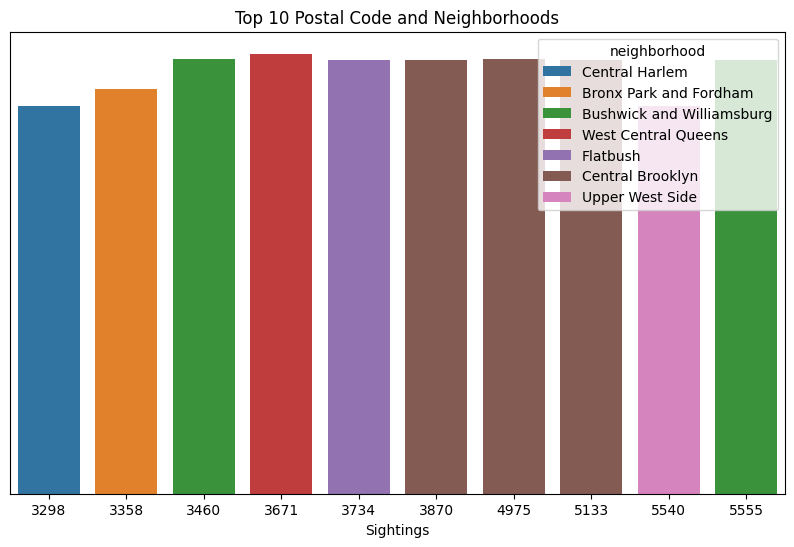

In [72]:
# Visualization, bar chart of the top ten sightings via neighborhood
top_10_zip_counts = zip_counts.head(10).reset_index(name='count')

plt.figure(figsize=(10,6))
sns.barplot(x='count', y='postalcode', data=top_10_zip_counts, hue='neighborhood',
            dodge=False)
plt.title('Top 10 Postal Code and Neighborhoods')
plt.xlabel('Sightings')
plt.ylabel('')
plt.yticks([])
plt.show()

In [73]:
# repeat offence neightborhoods
# count instances of zip codes
# Filter rows where 'repeat_offence' column equals 1
filtered_df = inspections[inspections['repeat_offence'] == 1]

# Count occurrences of unique combinations of 'postalcode', 'neighborhood_x', and 'repeat_offence'
offence_counts = filtered_df[['postalcode', 'neighborhood', 'repeat_offence']].value_counts()

# Display the top 10 counts
offence_counts.head(10)

postalcode  neighborhood                repeat_offence
11216       Central Brooklyn            1                 8149
11221       Bushwick and Williamsburg   1                 8091
10457       Central Bronx               1                 7815
10458       Bronx Park and Fordham      1                 7230
11237       Bushwick and Williamsburg   1                 6800
10456       High Bridge and Morrisania  1                 5930
11206       Bushwick and Williamsburg   1                 5103
10467       Bronx Park and Fordham      1                 4972
10468       Bronx Park and Fordham      1                 4934
10453       Central Bronx               1                 4650
Name: count, dtype: int64

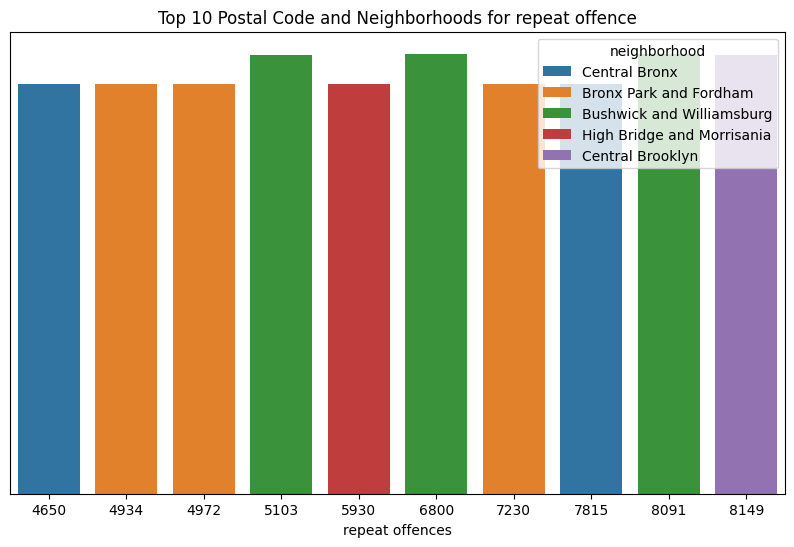

In [74]:
# Visualization, bar chart of the top ten sightings via neighborhood
top_10_offence = offence_counts.head(10).reset_index(name='count')

plt.figure(figsize=(10,6))
sns.barplot(x='count', y='postalcode', data=top_10_offence, hue='neighborhood',
            dodge=False)
plt.title('Top 10 Postal Code and Neighborhoods for repeat offence')
plt.xlabel('repeat offences')
plt.ylabel('')
plt.yticks([])
plt.show()

From my previous project I know there are some discrepinces in the community board column. I'll need to find them.


###  Save dfs to csv

In [75]:
#from google.colab import drive
#drive.mount('/content/drive')
#tonnage.to_csv('tonnage.csv')
#inspections.to_csv('inspections.csv')
#rat_df.to_csv('rat_df.csv')

In [76]:
#rat_df = pd.read_csv("rat_df.csv")
#inspections = pd.read_csv("inspections.csv")
#tonnage = pd.read_csv("tonnage.csv")

## Joining tonnage and rats
I'll join on the community board col or the month col.

Before I can merge them though I'll need to group the unique keys by month, and community board.

In [77]:
print(tonnage.info())
print(rat_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10154 entries, 1711 to 23590
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                10154 non-null  object 
 1   borough              10154 non-null  object 
 2   communitydistrict    10154 non-null  object 
 3   refusetonscollected  10148 non-null  float64
 4   papertonscollected   10148 non-null  float64
 5   mgptonscollected     10148 non-null  float64
 6   borough_id           10148 non-null  float64
 7   community_district   10154 non-null  object 
 8   totalcollection      10154 non-null  float64
dtypes: float64(5), object(4)
memory usage: 1.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209682 entries, 0 to 209681
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unique key       209682 non-null  object        
 1   created da

In [78]:
tons = tonnage.rename(columns={'community_district': 'community board'})
tons.head(1)

month borough communitydistrict  refusetonscollected  \
1711  2010 / 01  Queens                06               2569.1   

      papertonscollected  mgptonscollected  borough_id community board  \
1711               436.8             297.1         4.0       06 Queens   

      totalcollection  
1711           3303.0

In [79]:
rat_counts = rat_df.groupby(['community board', 'month'])['unique key'].count()
rat_counts.head(10)

community board  month  
01 Bronx         2010-01     6
                 2010-02     4
                 2010-03    13
                 2010-04    13
                 2010-05    18
                 2010-06    13
                 2010-07     6
                 2010-08    15
                 2010-09     8
                 2010-10     8
Name: unique key, dtype: int64

Before I go any further I want to check if the community boards cols are the same

In [80]:
tonstest = tons.groupby(['community board', 'month'])['refusetonscollected'].sum()
tonstest.head()

community board  month    
01 Bronx         2010 / 01    1925.8
                 2010 / 02    1641.1
                 2010 / 03    2246.7
                 2010 / 04    1900.9
                 2010 / 05    1872.0
Name: refusetonscollected, dtype: float64

In [81]:
# Merge the DataFrames on the columns you want to compare
merged_df = pd.merge(rat_df[['community board']], tons[['community board']], left_on='community board', right_on='community board', how='inner')

# Check if there are any matching values
matching_values_exist = not merged_df.empty

# Print the result
print("Matching values exist:", matching_values_exist)

Matching values exist: True


In [82]:
# To complete the merge dates need to be the same format
# convert the month cols
rat_df['month'] = pd.to_datetime(rat_df['month'])
# convert to month period
rat_df['month'] = rat_df['month'].dt.to_period('M')

# convert the month cols
tons['month'] = pd.to_datetime(tons['month'])
# convert to month period
tons['month'] = tons['month'].dt.to_period('M')

tons.info()
rat_df.info()

<ipython-input-82-c127dbe30a67>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tons['month'] = pd.to_datetime(tons['month'])


<class 'pandas.core.frame.DataFrame'>
Index: 10154 entries, 1711 to 23590
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype    
---  ------               --------------  -----    
 0   month                10154 non-null  period[M]
 1   borough              10154 non-null  object   
 2   communitydistrict    10154 non-null  object   
 3   refusetonscollected  10148 non-null  float64  
 4   papertonscollected   10148 non-null  float64  
 5   mgptonscollected     10148 non-null  float64  
 6   borough_id           10148 non-null  float64  
 7   community board      10154 non-null  object   
 8   totalcollection      10154 non-null  float64  
dtypes: float64(5), object(3), period[M](1)
memory usage: 1.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209682 entries, 0 to 209681
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unique key       209682 non-null 

In [83]:
merged_df = pd.merge(rat_df[['month']], tons[['month']], left_on='month', right_on='month', how='inner')

# Check if there are any matching values
matching_values_exist = not merged_df.empty

# Print the result
print("Matching values exist:", matching_values_exist)

Matching values exist: True


Now that I have the same community boards and months its time to see if can merge them

In [84]:
merged_df = pd.merge(rat_df, tons, on=['month', 'community board'], how='inner')

Leaving off here. Now all I need to do is create a sightings by month col using groupby or something and combine the two DFs so I have sightings by month, along with collections by month and community board.

In [85]:
merged_df.head()

unique key        created date  postalcode            location type  \
0   52294394 2021-10-25 09:51:21       10001    Other (Explain Below)   
1   52266780 2021-10-22 06:26:48       10001  3+ Family Apt. Building   
2   52362690 2021-10-30 10:36:43       10001        Construction Site   
3   52251576 2021-10-21 03:39:06       10001  3+ Family Apt. Building   
4   52078093 2021-10-04 12:48:49       10001  3+ Family Apt. Building   

  community board                                  location    month  \
0    04 Manhattan   (40.749272931504095, -73.9962501248835)  2021-10   
1    04 Manhattan    (40.74988232081192, -73.9988486803616)  2021-10   
2    04 Manhattan   (40.74521600429531, -73.99241770176174)  2021-10   
3    04 Manhattan  (40.749613303909804, -73.99706577088938)  2021-10   
4    04 Manhattan   (40.74923999191611, -73.99617072614878)  2021-10   

   borough_x         neighborhood  borough_y communitydistrict  \
0  Manhattan  Chelsea and Clinton  Manhattan                04   
1  Manhattan  Chelsea and Clinton  Manhattan                04   
2  Manhattan  Chelsea and Clinton  Manhattan                04   
3  Manhattan  Chelsea and Clinton  Manhattan                04   
4  Manhattan  Chelsea and Clinton  Manhattan                04   

   refusetonscollected  papertonscollected  mgptonscollected  borough_id  \
0               2494.0               558.0             400.4         1.0   
1               2494.0               558.0             400.4         1.0   
2               2494.0               558.0             400.4         1.0   
3               2494.0               558.0             400.4         1.0   
4               2494.0               558.0             400.4         1.0   

   totalcollection  
0           3452.4  
1           3452.4  
2           3452.4  
3           3452.4  
4           3452.4

In [86]:
# get tonnage in groupby include all trash
ton_count = tons.groupby(['community board', 'month'])[['refusetonscollected', 'papertonscollected', 'mgptonscollected', 'totalcollection']].sum()
ton_count.head()

refusetonscollected  papertonscollected  \
community board month                                              
01 Bronx        2010-01               1925.8                85.0   
                2010-02               1641.1                70.5   
                2010-03               2246.7               103.8   
                2010-04               1900.9                90.2   
                2010-05               1872.0                84.0   

                         mgptonscollected  totalcollection  
community board month                                       
01 Bronx        2010-01              84.0           2094.8  
                2010-02              62.7           1774.3  
                2010-03              88.3           2438.8  
                2010-04              81.8           2072.9  
                2010-05              72.9           2028.9

In [87]:
inspections.info()
inspections.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447403 entries, 0 to 2447402
Data columns (total 13 columns):
 #   Column           Dtype         
---  ------           -----         
 0   inspection_date  datetime64[ns]
 1   inspection_type  object        
 2   result           object        
 3   postalcode       int64         
 4   borough          object        
 5   cb_id            object        
 6   location         object        
 7   month            period[M]     
 8   community board  object        
 9   no_activity      int64         
 10  activity         int64         
 11  repeat_offence   int64         
 12  neighborhood     object        
dtypes: datetime64[ns](1), int64(4), object(7), period[M](1)
memory usage: 242.7+ MB


inspection_date inspection_type  result  postalcode borough cb_id  \
0 2016-10-04 02:02:02         Initial  Passed       11103  Queens     1   

                              location    month community board  no_activity  \
0  (40.756447260573, -73.917724430674)  2016-10        1 Queens            1   

   activity  repeat_offence      neighborhood  
0         0               0  Northwest Queens

### joining inspection data

In [88]:
inspection_count = inspections.groupby(['community board', 'month'])[['no_activity','activity', 'repeat_offence']].sum()

inspection_count.head()

no_activity  activity  repeat_offence
community board month                                         
1 Bronx         2009-09            8        18               0
                2009-10           13        13               0
                2009-11           23         8               3
                2009-12           12        16               6
                2010-01           15        26               7

In [89]:
# Convert rat_counts and ton_count to DFs
rat_count = pd.DataFrame(rat_counts)
ton_count = pd.DataFrame(ton_count)
inspection_count = pd.DataFrame(inspection_count)

In [90]:
nan_values = inspection_count.isna().sum()
print(nan_values)

no_activity       0
activity          0
repeat_offence    0
dtype: int64


In [91]:
ton_count.info()
rat_count.info()
inspection_count.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10154 entries, ('01 Bronx', Period('2010-01', 'M')) to ('7A Queens', Period('2022-12', 'M'))
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   refusetonscollected  10154 non-null  float64
 1   papertonscollected   10154 non-null  float64
 2   mgptonscollected     10154 non-null  float64
 3   totalcollection      10154 non-null  float64
dtypes: float64(4)
memory usage: 349.0+ KB
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10054 entries, ('01 Bronx', '2010-01') to ('18 Brooklyn', '2024-04')
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   unique key  10054 non-null  int64
dtypes: int64(1)
memory usage: 112.0+ KB
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10244 entries, ('1 Bronx', Period('2009-09', 'M')) to ('9 Queens', Period('2024-04', 'M'))
Data columns (total 3 columns):


In [92]:
# reset the indeices of the new DFs
ton_count = ton_count.reset_index()
ton_count.head()


rat_count = rat_count.reset_index()
rat_count.head()

inspection_count = inspection_count.reset_index()
inspection_count.head()

community board    month  no_activity  activity  repeat_offence
0         1 Bronx  2009-09            8        18               0
1         1 Bronx  2009-10           13        13               0
2         1 Bronx  2009-11           23         8               3
3         1 Bronx  2009-12           12        16               6
4         1 Bronx  2010-01           15        26               7

In [93]:
inspection_count['community board'].value_counts()

community board
2 Staten Island    177
17 Brooklyn        176
3 Manhattan        176
4 Bronx            176
7 Bronx            176
4 Manhattan        176
12 Manhattan       176
5 Brooklyn         175
1 Brooklyn         175
3 Brooklyn         175
3 Staten Island    175
4 Brooklyn         175
5 Bronx            175
5 Manhattan        175
2 Brooklyn         175
6 Bronx            175
6 Brooklyn         175
7 Manhattan        175
8 Bronx            175
8 Brooklyn         175
8 Manhattan        175
9 Bronx            175
9 Brooklyn         175
9 Manhattan        175
2 Manhattan        175
1 Bronx            175
2 Bronx            175
1 Manhattan        175
16 Brooklyn        175
1 Queens           175
1 Staten Island    175
10 Manhattan       175
14 Brooklyn        175
11 Bronx           175
12 Queens          175
11 Manhattan       175
12 Bronx           175
18 Brooklyn        174
10 Bronx           174
7 Queens           174
6 Manhattan        174
5 Queens           174
13 Queens         

In [94]:
# Convert the 'object' type column to 'period' type
rat_count['month'] = pd.to_datetime(rat_count['month']).dt.to_period('M')

#### Solving missing Staten Island
Staten Island disappears when I run the following code, but so does all the community boards that aren't double digits. It is because inspections has a format of '1 Bronx' while the others have a format of '01 Bronx'

In [95]:
# Create a fucntion to standize the community board formats
def standardize_community_board(board):
  parts = board.split()
  if len(parts[0]) == 1:
    parts[0] = '0' + parts[0]
  return ''.join(parts)

rat_count['community board'] = rat_count['community board'].apply(standardize_community_board)
ton_count['community board'] = ton_count['community board'].apply(standardize_community_board)
inspection_count['community board'] = inspection_count['community board'].apply(standardize_community_board)

In [96]:
rat_count.head()

community board    month  unique key
0         01Bronx  2010-01           6
1         01Bronx  2010-02           4
2         01Bronx  2010-03          13
3         01Bronx  2010-04          13
4         01Bronx  2010-05          18

In [97]:
# Now, perform the merge
mergedcounts = pd.merge(rat_count, ton_count, on=['month', 'community board'])
mergedcounts = pd.merge(mergedcounts, inspection_count, on=['month', 'community board'])
mergedcounts.sample(5)

community board    month  unique key  refusetonscollected  \
4515        06Queens  2018-07           7               2887.9   
7095     10Manhattan  2024-02          66               2253.8   
7384         11Bronx  2019-12          19               2866.3   
1980      03Brooklyn  2019-06         130               4012.5   
2078     03Manhattan  2013-05          19               3173.3   

      papertonscollected  mgptonscollected  totalcollection  no_activity  \
4515               409.2             348.3           3645.4            9   
7095               221.9             208.4           2684.1          567   
7384               350.8             380.7           3597.8          152   
1980               331.5             348.7           4692.7         1553   
2078               353.1             277.4           3803.8          276   

      activity  repeat_offence  
4515        44               7  
7095       597             131  
7384        94              24  
1980       695             116  
2078       129              11

In [98]:
# drop the index in necessry
#mergedcounts = mergedcounts.drop(columns={'index'})
#mergedcounts.head(1)

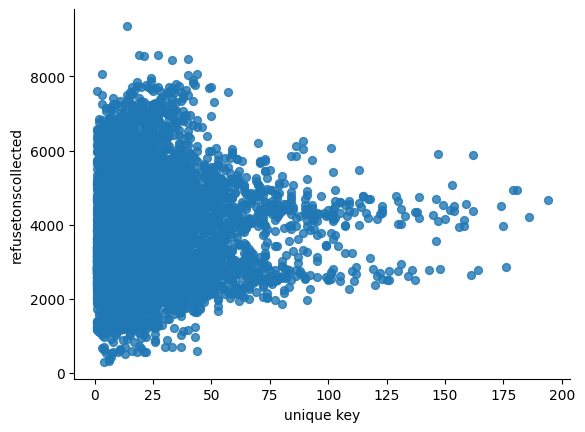

In [99]:
# @title sightings vs refusetonscollected
mergedcounts.plot(kind='scatter', x='unique key', y='refusetonscollected', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

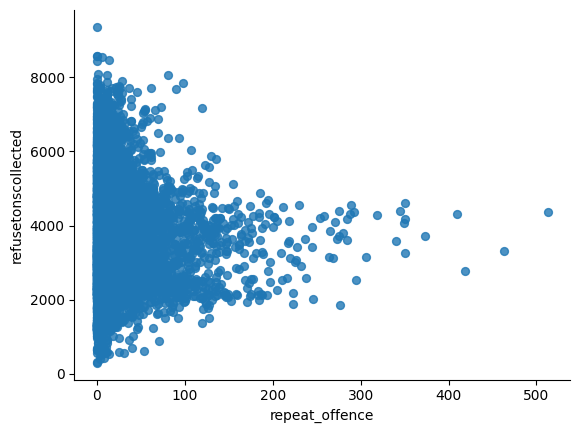

In [100]:
# @title repeat offence vs refusetonscollected
mergedcounts.plot(kind='scatter', x='repeat_offence', y='refusetonscollected', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

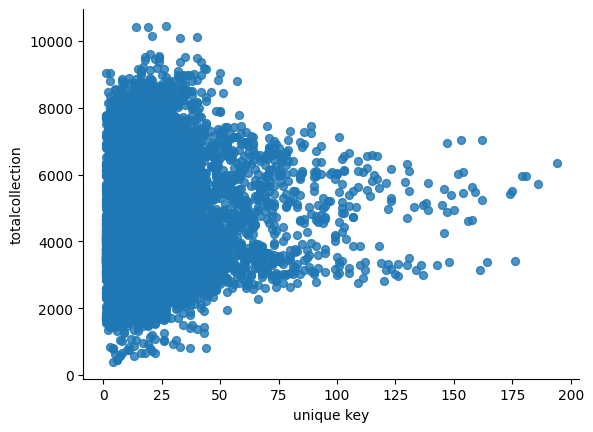

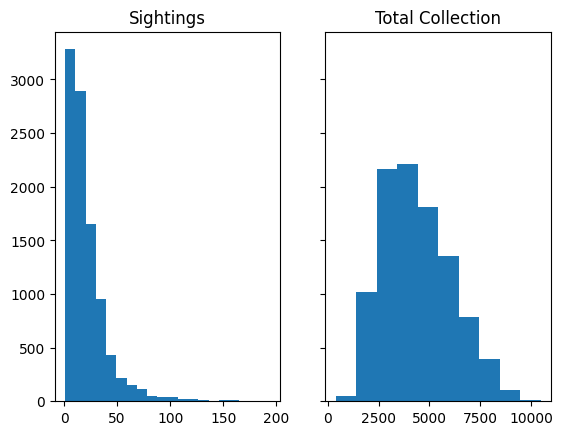

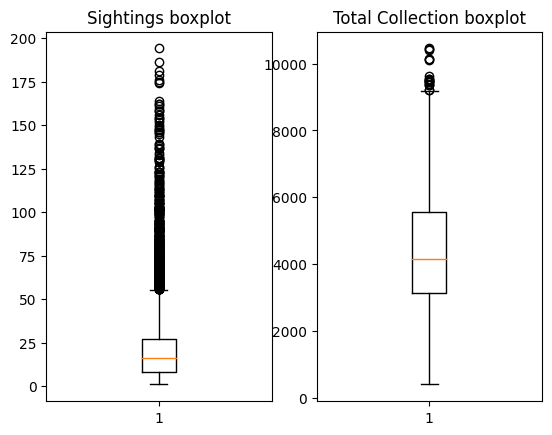

In [101]:
# @title sightings vs total collection
mergedcounts.plot(kind='scatter', x='unique key', y='totalcollection', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

fig, axs=plt.subplots(ncols=2, sharey=True)
axs[0].hist(mergedcounts['unique key'], bins=20)
axs[0].set_title('Sightings')
axs[1].hist(mergedcounts['totalcollection'], bins=10)
axs[1].set_title('Total Collection')
plt.show()

fig, axs=plt.subplots(ncols=2)
axs[0].boxplot(mergedcounts['unique key'])
axs[0].set_title('Sightings boxplot')
axs[1].boxplot(mergedcounts['totalcollection'])
axs[1].set_title('Total Collection boxplot')
plt.show()

In [102]:
mergedcounts.describe()

unique key  refusetonscollected  papertonscollected  mgptonscollected  \
count  9917.000000          9917.000000         9917.000000       9917.000000   
mean     20.973984          3596.672058          413.123767        375.752768   
std      19.771239          1385.768756          222.790530        176.095941   
min       1.000000           298.400000           21.200000         30.200000   
25%       8.000000          2452.400000          252.100000        246.800000   
50%      16.000000          3436.500000          385.400000        354.000000   
75%      27.000000          4586.800000          526.300000        468.400000   
max     194.000000          9363.100000         1937.500000       1250.500000   

       totalcollection  no_activity     activity  repeat_offence  
count      9917.000000  9917.000000  9917.000000     9917.000000  
mean       4385.548593   149.486538    95.128265       19.513865  
std        1677.591595   403.920623   131.961029       33.157197  
min         394.100000     0.000000     0.000000        0.000000  
25%        3121.700000    14.000000    19.000000        3.000000  
50%        4154.200000    25.000000    47.000000        9.000000  
75%        5550.600000    56.000000   110.000000       21.000000  
max       10455.000000  4939.000000  1586.000000      513.000000

<ipython-input-103-b72857ef6982>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mergedcounts['unique key']);


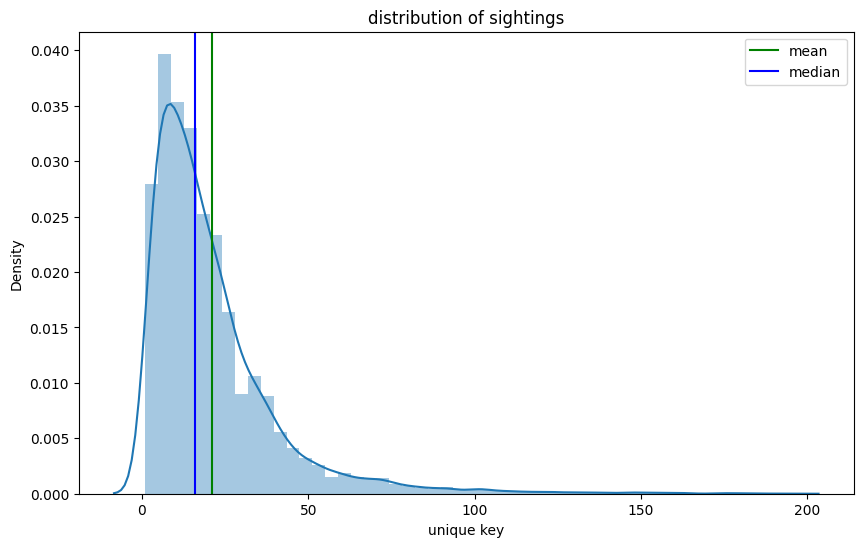

In [103]:
# check out the mean of the
mean=mergedcounts['unique key'].mean();
mode=mergedcounts['unique key'].mode();
median=mergedcounts['unique key'].median();

fig, ax = plt.subplots(figsize=(10,6));

sns.distplot(mergedcounts['unique key']);
plt.title('distribution of sightings');
plt.axvline(mean,color='green',label='mean');
plt.axvline(median,color='blue',label='median');

plt.legend();

In [104]:
# create a DF for plotly
# seperate the community board name for boros and convert period to object
plotlymerge = mergedcounts
plotlymerge['boro'] = mergedcounts['community board'].str.extract('([a-zA-Z]+)')

plotlymerge['month'] = plotlymerge['month'].astype(str)
plotlymerge.head()

community board    month  unique key  refusetonscollected  \
0         01Bronx  2010-01           6               1925.8   
1         01Bronx  2010-02           4               1641.1   
2         01Bronx  2010-03          13               2246.7   
3         01Bronx  2010-04          13               1900.9   
4         01Bronx  2010-05          18               1872.0   

   papertonscollected  mgptonscollected  totalcollection  no_activity  \
0                85.0              84.0           2094.8           15   
1                70.5              62.7           1774.3           10   
2               103.8              88.3           2438.8           20   
3                90.2              81.8           2072.9           12   
4                84.0              72.9           2028.9         3336   

   activity  repeat_offence   boro  
0        26               7  Bronx  
1        12               1  Bronx  
2        29               6  Bronx  
3        36               1  Bronx  
4       361               4  Bronx

In [105]:
plotlymerge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9917 entries, 0 to 9916
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   community board      9917 non-null   object 
 1   month                9917 non-null   object 
 2   unique key           9917 non-null   int64  
 3   refusetonscollected  9917 non-null   float64
 4   papertonscollected   9917 non-null   float64
 5   mgptonscollected     9917 non-null   float64
 6   totalcollection      9917 non-null   float64
 7   no_activity          9917 non-null   int64  
 8   activity             9917 non-null   int64  
 9   repeat_offence       9917 non-null   int64  
 10  boro                 9917 non-null   object 
dtypes: float64(4), int64(4), object(3)
memory usage: 852.4+ KB


In [106]:
# make an interactive plot for exploring the boroughs and time
import plotly.express as px

# Create the interactive scatter plot
fig = px.scatter(plotlymerge, x='unique key', y='totalcollection',
                 title='Rat sightings vs Total collection',
                 color='boro',
                 hover_name='community board', hover_data={'community board': True, 'month':True},
                 opacity=0.7)

fig.show()

In [107]:
# make an interactive plot for exploring the boroughs and time
import plotly.express as px

# Create the interactive scatter plot
fig = px.scatter(plotlymerge, x='activity', y='totalcollection',
                 title='Rat activity vs Total collection',
                 color='boro',
                 hover_name='community board', hover_data={'community board': True, 'month':True},
                 opacity=0.7)

fig.show()

In [108]:
print(plotlymerge['boro'].value_counts())

boro
Brooklyn        3050
Queens          2274
Manhattan       2043
Bronx           2038
StatenIsland     512
Name: count, dtype: int64


## Check the correlation

In [109]:
numeric_feats = mergedcounts.select_dtypes(include=[np.number])
corr = numeric_feats.corr()
print(corr['unique key'].sort_values(ascending=False))



unique key             1.000000
activity               0.501957
repeat_offence         0.421832
no_activity            0.207448
mgptonscollected       0.139635
totalcollection        0.103126
refusetonscollected    0.094172
papertonscollected     0.080406
Name: unique key, dtype: float64


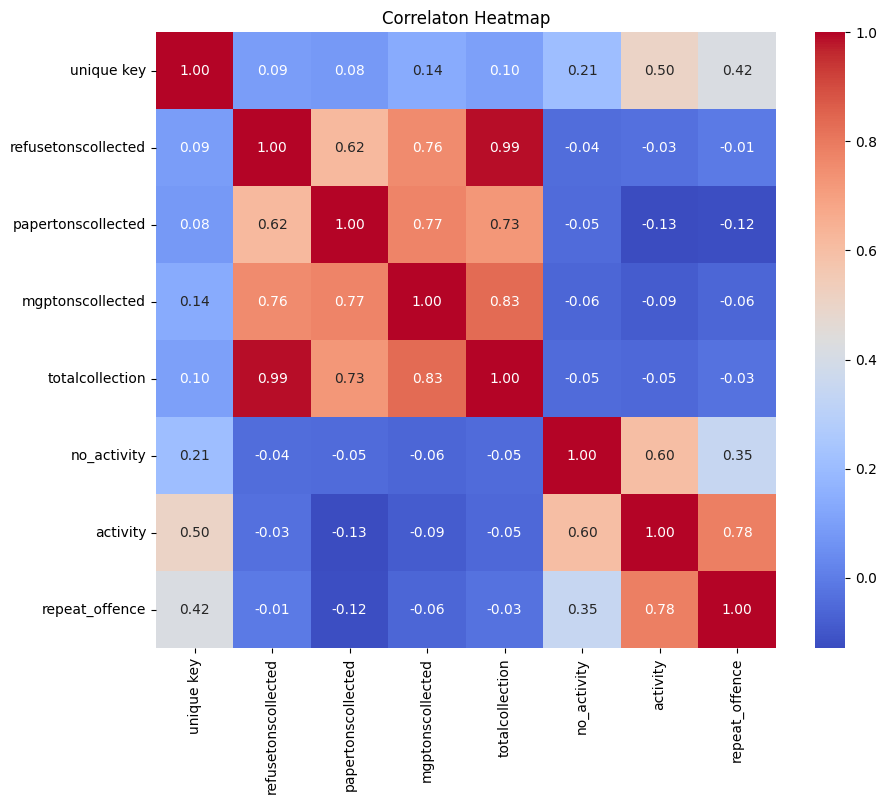

In [110]:
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlaton Heatmap')
plt.show()

MGP tonnage was the most correlated with rat sightings when just the tonnage and sightings were linked. Now with the rodent inspection the activity and repeat offence are the most correlated

Moving onto some correlation tests:
This quantitative measure can indicate the strength and direction of the linear relationship between the two variables.

In [111]:
# Pearson's correlation coefficient
import scipy.stats as stats
column1=mergedcounts['unique key'];
column2=mergedcounts['mgptonscollected'];


In [112]:
# pearson correlation
corrPearson, pValPearson = stats.pearsonr(column1,column2)
print ("Pearson's correlation for sighting and mgp tons is:", corrPearson, "with a p-value of",pValPearson)

# spearman
corrSpearman, pValSpearman = stats.spearmanr(column1,column2)
print ("Spearman's correlation for sighting and mgp tons is:", corrSpearman, "with a p-value of",pValSpearman)

Pearson's correlation for sighting and mgp tons is: 0.13963532673856494 with a p-value of 2.303655244091751e-44
Spearman's correlation for sighting and mgp tons is: 0.11708743538114395 with a p-value of 1.2920872178858758e-31


prior pearson correlation scores to just tonnage and sightings:


Pearson's correlation is 0.13919941055200097 with a p-value of 1.1107154256742393e-44
Spearman's correlation is 0.11873160192541404 with a p-value of 6.815035279641245e-33

In [113]:
# Pearson and spearman for activity and sighting
column1=mergedcounts['unique key'];
column2=mergedcounts['activity'];

In [114]:
# pearson correlation
corrPearson, pValPearson = stats.pearsonr(column1,column2)
print ("Pearson's correlation for sighting and activity is:", corrPearson, "with a p-value of",pValPearson)

# spearman
corrSpearman, pValSpearman = stats.spearmanr(column1,column2)
print ("Spearman's correlation for sighting and activity is:", corrSpearman, "with a p-value of",pValSpearman)

Pearson's correlation for sighting and activity is: 0.5019573556124143 with a p-value of 0.0
Spearman's correlation for sighting and activity is: 0.5772730697809693 with a p-value of 0.0


## Linear Regression test


Does unique key work?

In [115]:
mergedcounts.head(3)

community board    month  unique key  refusetonscollected  \
0         01Bronx  2010-01           6               1925.8   
1         01Bronx  2010-02           4               1641.1   
2         01Bronx  2010-03          13               2246.7   

   papertonscollected  mgptonscollected  totalcollection  no_activity  \
0                85.0              84.0           2094.8           15   
1                70.5              62.7           1774.3           10   
2               103.8              88.3           2438.8           20   

   activity  repeat_offence   boro  
0        26               7  Bronx  
1        12               1  Bronx  
2        29               6  Bronx

In [116]:
# Simple linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# mgp is independent(predictor), unique key is the target
model.fit(mergedcounts[['mgptonscollected']],mergedcounts['unique key'])
print('intercept:', model.intercept_)
print('slope:', model.coef_)

intercept: 15.083078746734358
slope: [0.01567761]


In [117]:
r_sq=model.score(mergedcounts[['mgptonscollected']],mergedcounts['unique key'])
[print("R2=", r_sq)]

R2= 0.019498024473385778


[None]

In [118]:
# Simple linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# activity is independent(predictor), unique key is the target
model.fit(mergedcounts[['activity']],mergedcounts['unique key'])
print('intercept:', model.intercept_)
print('slope:', model.coef_)

intercept: 13.819726065342177
slope: [0.07520644]


so for 1 increase in rat activity there is a .07 increase in sightings.

In [119]:
r_sq=model.score(mergedcounts[['activity']],mergedcounts['unique key'])
[print("R2=", r_sq)]

R2= 0.2519611868534082


[None]

In [120]:
column1=mergedcounts['unique key'];
column2=mergedcounts['activity'];
slope, intercept, r_value, p_value, std_err = stats.linregress(column1, column2)
print ("Slope: ", slope)
print ("Intercept: ", intercept)
print ("p_value: ", p_value)
print ("std_err: ", std_err)

Slope:  3.350260843660102
Intercept:  24.859947038372752
p_value:  0.0
std_err:  0.05797323105125064


In [121]:
# multiple regression using activity, no acitivty, mgp, and repeat offence
import statsmodels.api as sm

# dependent variable will be sightings aka unique key
dependent = mergedcounts['unique key']

# independent variables
independents = mergedcounts[['activity','no_activity', 'repeat_offence', 'mgptonscollected']]
# add the intercepts
independents_withconst = sm.add_constant(independents)

# use the OLS function
model = sm.OLS(dependent, independents_withconst)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             unique key   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     1059.
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        08:42:19   Log-Likelihood:                -41901.
No. Observations:                9917   AIC:                         8.381e+04
Df Residuals:                    9912   BIC:                         8.385e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.6896      0.420  

### Results from regression.
Can expand on this with the titanic example from lab 5. See stats text book to fully understand what happened here.

Overall it doesn't seem that trash is a good predictor of rats. Rodent inspections is better with activity being the best. Repeat offence also offers insights.

# Time Series

In [122]:
mergedcounts.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9917 entries, 0 to 9916
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   community board      9917 non-null   object 
 1   month                9917 non-null   object 
 2   unique key           9917 non-null   int64  
 3   refusetonscollected  9917 non-null   float64
 4   papertonscollected   9917 non-null   float64
 5   mgptonscollected     9917 non-null   float64
 6   totalcollection      9917 non-null   float64
 7   no_activity          9917 non-null   int64  
 8   activity             9917 non-null   int64  
 9   repeat_offence       9917 non-null   int64  
 10  boro                 9917 non-null   object 
dtypes: float64(4), int64(4), object(3)
memory usage: 852.4+ KB


In [123]:
# change month back to a period
mergedcounts['month'] = pd.to_datetime(mergedcounts['month']).dt.to_period('M')

mergedcounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9917 entries, 0 to 9916
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype    
---  ------               --------------  -----    
 0   community board      9917 non-null   object   
 1   month                9917 non-null   period[M]
 2   unique key           9917 non-null   int64    
 3   refusetonscollected  9917 non-null   float64  
 4   papertonscollected   9917 non-null   float64  
 5   mgptonscollected     9917 non-null   float64  
 6   totalcollection      9917 non-null   float64  
 7   no_activity          9917 non-null   int64    
 8   activity             9917 non-null   int64    
 9   repeat_offence       9917 non-null   int64    
 10  boro                 9917 non-null   object   
dtypes: float64(4), int64(4), object(2), period[M](1)
memory usage: 852.4+ KB


In [124]:
mindate = mergedcounts['month'].min()
maxdate =mergedcounts['month'].max()
print(f'mindate = {mindate}, maxdate = {maxdate}')

mindate = 2010-01, maxdate = 2024-04


In [212]:
ratforcast=rat_df
ratforcast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209682 entries, 0 to 209681
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unique key       209682 non-null  object        
 1   created date     209682 non-null  datetime64[ns]
 2   postalcode       209682 non-null  int64         
 3   location type    209682 non-null  object        
 4   community board  209682 non-null  object        
 5   location         209682 non-null  object        
 6   month            209682 non-null  period[M]     
 7   borough          209682 non-null  object        
 8   neighborhood     209682 non-null  object        
 9   sighting         209682 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(6), period[M](1)
memory usage: 16.0+ MB


In [213]:
# create a boolean col for sighting based on unique key
ratforcast['sighting'] = (~ratforcast['unique key'].isnull()).astype(float)
ratforcast.head(3)

unique key        created date  postalcode            location type  \
0   52294394 2021-10-25 09:51:21       10001    Other (Explain Below)   
1   27944790 2014-04-30 12:00:00       10001  3+ Family Apt. Building   
2   19630346 2011-01-19 12:00:00       10001          Office Building   

  community board                                  location    month  \
0    04 Manhattan   (40.749272931504095, -73.9962501248835)  2021-10   
1    04 Manhattan   (40.75042849369146, -73.99705490743705)  2014-04   
2    04 Manhattan  (40.749638039983026, -73.99903635982373)  2011-01   

     borough         neighborhood   sighting  
0  Manhattan  Chelsea and Clinton 1.00000000  
1  Manhattan  Chelsea and Clinton 1.00000000  
2  Manhattan  Chelsea and Clinton 1.00000000

In [214]:
mindate = ratforcast['created date'].min()
maxdate =ratforcast['created date'].max()
print(f'mindate = {mindate}, maxdate = {maxdate}')

mindate = 2010-01-01 02:15:27, maxdate = 2024-04-17 12:58:41


In [215]:
# drop cols I wont be using
ratforcast = ratforcast.drop(columns=['postalcode', 'unique key', 'location', 'month', 'location type'])

In [216]:
ratforcast.head()

created date community board    borough         neighborhood  \
0 2021-10-25 09:51:21    04 Manhattan  Manhattan  Chelsea and Clinton   
1 2014-04-30 12:00:00    04 Manhattan  Manhattan  Chelsea and Clinton   
2 2011-01-19 12:00:00    04 Manhattan  Manhattan  Chelsea and Clinton   
3 2011-03-29 12:00:00    05 Manhattan  Manhattan  Chelsea and Clinton   
4 2019-04-16 07:30:52    05 Manhattan  Manhattan  Chelsea and Clinton   

    sighting  
0 1.00000000  
1 1.00000000  
2 1.00000000  
3 1.00000000  
4 1.00000000

In [217]:
# Set some Month, Week and Q
ratforcast = ratforcast.set_index('created date')
ratforcast = ratforcast.sort_index(ascending=True)
ratforcast.head(2)

community board    borough                   neighborhood  \
created date                                                                    
2010-01-01 02:15:27     12 Brooklyn   Brooklyn                   Borough Park   
2010-01-01 03:05:37       01 Queens     Queens                    West Queens   
2010-01-01 04:14:27        11 Bronx      Bronx         Bronx Park and Fordham   
2010-01-01 08:29:58     03 Brooklyn   Brooklyn      Bushwick and Williamsburg   
2010-01-01 08:52:19     02 Brooklyn   Brooklyn             Northwest Brooklyn   
2010-01-01 11:20:45       07 Queens     Queens                 Central Queens   
2010-01-01 11:46:51     02 Brooklyn   Brooklyn             Northwest Brooklyn   
2010-01-01 12:11:51    10 Manhattan  Manhattan                 Central Harlem   
2010-01-01 12:12:04        06 Bronx      Bronx         Bronx Park and Fordham   
2010-01-02 01:07:42        04 Bronx      Bronx     High Bridge and Morrisania   
2010-01-02 01:37:04     18 Brooklyn   Brooklyn         Canarsie and Flatlands   
2010-01-02 06:27:59     03 Brooklyn   Brooklyn               Central Brooklyn   
2010-01-02 07:09:56     11 Brooklyn   Brooklyn                   Borough Park   
2010-01-02 09:04:46       06 Queens     Queens            West Central Queens   
2010-01-02 09:38:29       12 Queens     Queens                        Jamaica   
2010-01-02 11:06:30        02 Bronx      Bronx     Hunts Point and Mott Haven   
2010-01-02 11:27:03     07 Brooklyn   Brooklyn                    Sunset Park   
2010-01-02 12:09:47       01 Queens     Queens                    West Queens   
2010-01-02 12:49:49        01 Bronx      Bronx     Hunts Point and Mott Haven   
2010-01-02 12:50:16    12 Manhattan  Manhattan  Inwood and Washington Heights   

                      sighting  
created date                    
2010-01-01 02:15:27 1.00000000  
2010-01-01 03:05:37 1.00000000  
2010-01-01 04:14:27 1.00000000  
2010-01-01 08:29:58 1.00000000  
2010-01-01 08:52:19 1.00000000  
2010-01-01 11:20:45 1.00000000  
2010-01-01 11:46:51 1.00000000  
2010-01-01 12:11:51 1.00000000  
2010-01-01 12:12:04 1.00000000  
2010-01-02 01:07:42 1.00000000  
2010-01-02 01:37:04 1.00000000  
2010-01-02 06:27:59 1.00000000  
2010-01-02 07:09:56 1.00000000  
2010-01-02 09:04:46 1.00000000  
2010-01-02 09:38:29 1.00000000  
2010-01-02 11:06:30 1.00000000  
2010-01-02 11:27:03 1.00000000  
2010-01-02 12:09:47 1.00000000  
2010-01-02 12:49:49 1.00000000  
2010-01-02 12:50:16 1.00000000

#### Boro Dfs
replace the city DF with whichever boro DF you'd like to examine

In [221]:
brooklyn_rats = ratforcast.loc[(ratforcast['borough'] == 'Brooklyn') & (ratforcast['sighting']), :]
bronx_rats = ratforcast.loc[(ratforcast['borough'] == 'Bronx') & (ratforcast['sighting']), :]
manhattan_rats = ratforcast.loc[(ratforcast['borough'] == 'Manhattan') & (ratforcast['sighting']), :]
queens_rats = ratforcast.loc[(ratforcast['borough'] == 'Queens') & (ratforcast['sighting']), :]
staten_rats = ratforcast.loc[(ratforcast['borough'] == 'Staten Island') & (ratforcast['sighting']), :]

In [131]:
# Monthly period,
ratforcastM = ratforcast[mindate:maxdate].resample('M').count()
# weekly
ratforcastWW = ratforcast[mindate:maxdate].resample('W').count()
#Quarterly
ratforcastQ = ratforcast[mindate:maxdate].resample('Q').count()


In [132]:
ratforcastM.head()

community board  borough  neighborhood  sighting
created date                                                  
2010-01-31                526      526           526       526
2010-02-28                420      420           420       420
2010-03-31                825      825           825       825
2010-04-30                905      905           905       905
2010-05-31               1062     1062          1062      1062

In [133]:
# Select the proper time period for monthly aggreagation
ratforcast = ratforcast['2010-01':'2024-04'].resample('M').sum()
ratforcast.head()

community board  \
created date                                                      
2010-01-31    12 Brooklyn01 Queens11 Bronx03 Brooklyn02 Broo...   
2010-02-28    04 Bronx17 Brooklyn18 Brooklyn12 Brooklyn05 Br...   
2010-03-31    13 Queens04 Bronx01 Bronx12 Queens17 Brooklyn1...   
2010-04-30    03 Bronx01 Staten Island11 Manhattan03 Queens0...   
2010-05-31    09 Bronx06 Brooklyn05 Brooklyn14 Queens07 Quee...   

                                                        borough  \
created date                                                      
2010-01-31    BrooklynQueensBronxBrooklynBrooklynQueensBrook...   
2010-02-28    BronxBrooklynBrooklynBrooklynBronxBrooklynBroo...   
2010-03-31    QueensBronxBronxQueensBrooklynBronxManhattanBr...   
2010-04-30    BronxStaten IslandManhattanQueensQueensQueensB...   
2010-05-31    BronxBrooklynBrooklynQueensQueensBronxStaten I...   

                                                   neighborhood  sighting  
created date                                                               
2010-01-31    Borough ParkWest QueensBronx Park and FordhamB...     526.0  
2010-02-28    High Bridge and MorrisaniaFlatbushCanarsie and...     420.0  
2010-03-31    Southeast QueensCentral BronxHunts Point and M...     825.0  
2010-04-30    Central BronxStapleton and St. GeorgeEast Harl...     905.0  
2010-05-31    Southeast BronxNorthwest BrooklynEast New York...    1062.0

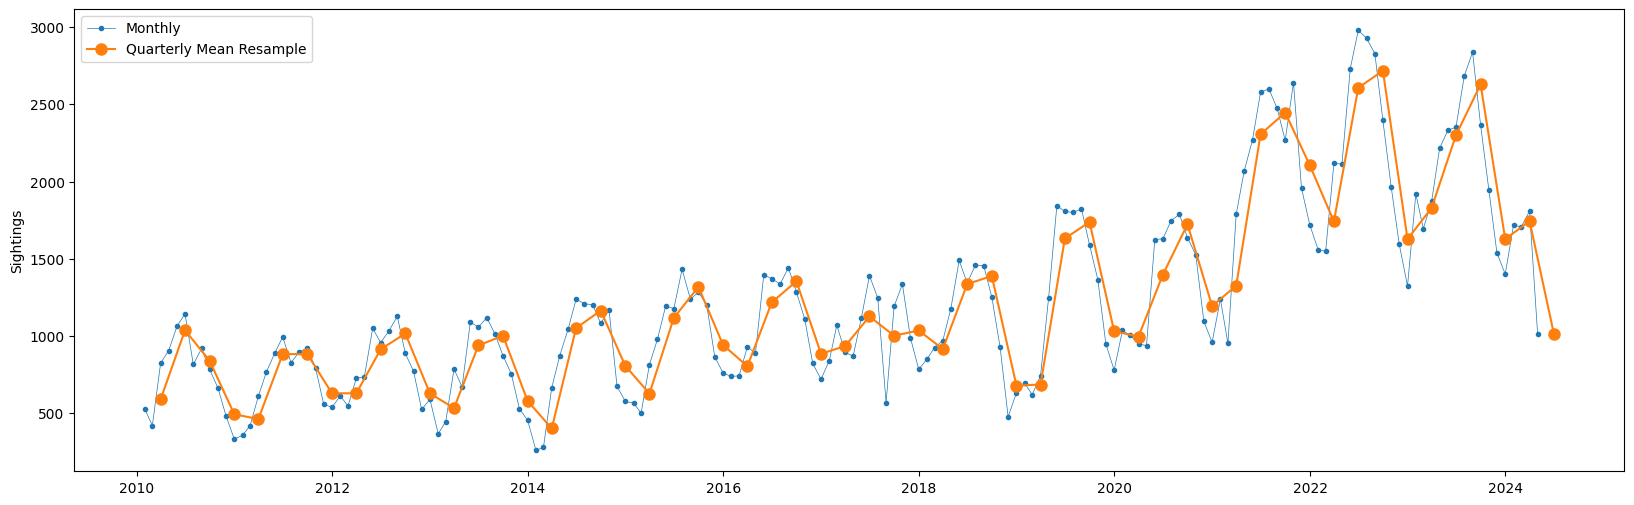

In [134]:
# Monthly vs Quarterly mean sighting
y=ratforcastM['sighting']
fig, ax=plt.subplots(figsize=(20,6))
ax.plot(y, marker='.', linestyle='-', linewidth=0.5, label='Monthly')
ax.plot(y.resample('Q').mean(), marker='o', markersize=8, linestyle='-', label='Quarterly Mean Resample')
ax.set_ylabel('Sightings')
ax.legend();

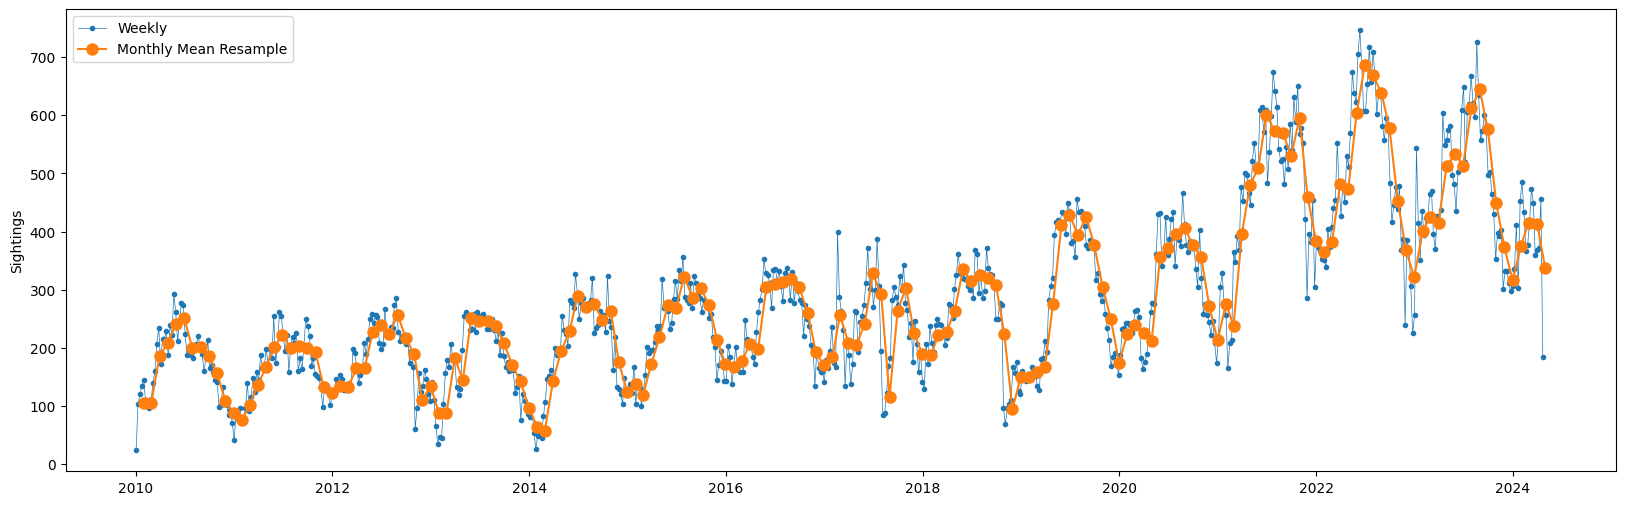

In [135]:
# Weekly vs monthly mean sighting
y=ratforcastWW['sighting']
fig, ax=plt.subplots(figsize=(20,6))
ax.plot(y, marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(), marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Sightings')
ax.legend();

In [136]:
# graph to season seasonal_decompose
def seasonal_decompose (y):
  decomposition = sm.tsa.seasonal_decompose(y, model='additive', extrapolate_trend='freq')
  fig = decomposition.plot()
  fig.set_size_inches(14,7)
  plt.show()

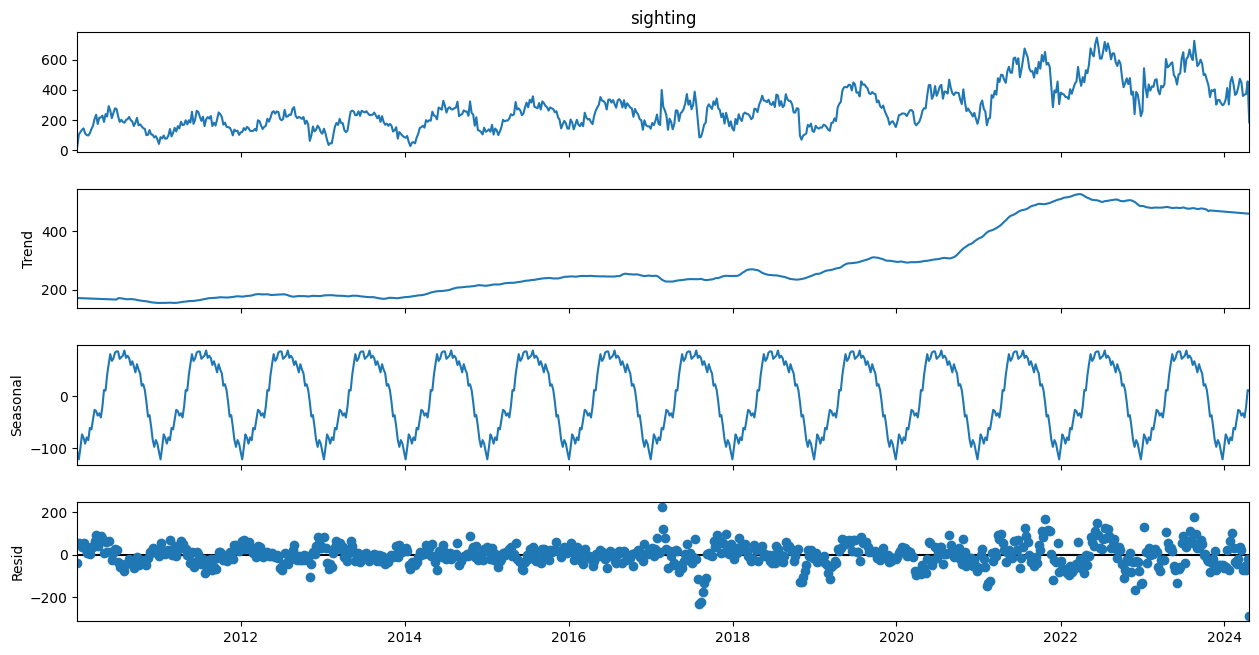

In [137]:
seasonal_decompose(y)

#### Test Stationary
A dataset is stationary if its statistical properties like mean, variance and autocorrelation do not change over time

In [138]:
# plot for rolling statistic for stationary
def test_stationary(timeseries, title):

  # determine rolling stats
  rolmean = pd.Series(timeseries).rolling(window=12).mean()
  rolstd = pd.Series(timeseries).rolling(window=12).std()

  fif, ax = plt.subplots(figsize=(16,4))
  ax.plot(timeseries, label=title)
  ax.plot(rolmean, label='rolling mean')
  ax.plot(rolstd, label='rolling std (x10)');
  ax.legend()

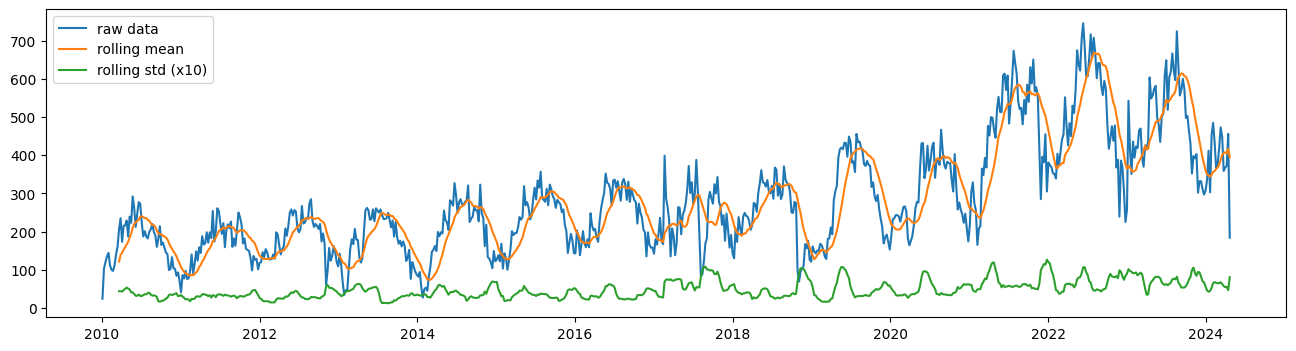

In [139]:
pd.options.display.float_format = '{:.8f}'.format
test_stationary(y, 'raw data')

In [140]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [141]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -3.103
P-value = 0.026
Critical values :
	1%: -3.439181811684251 - The data is not stationary with 99% confidence
	5%: -2.865437807603377 - The data is  stationary with 95% confidence
	10%: -2.5688456132154935 - The data is  stationary with 90% confidence


## Read this:
https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

#### Detrending

 > Is the de-trended data stationary ?
Test statistic = -8.154
P-value = 0.000
Critical values :
	1%: -3.4395289262948894 - The data is  stationary with 99% confidence
	5%: -2.8655907692307694 - The data is  stationary with 95% confidence
	10%: -2.5689271030368235 - The data is  stationary with 90% confidence


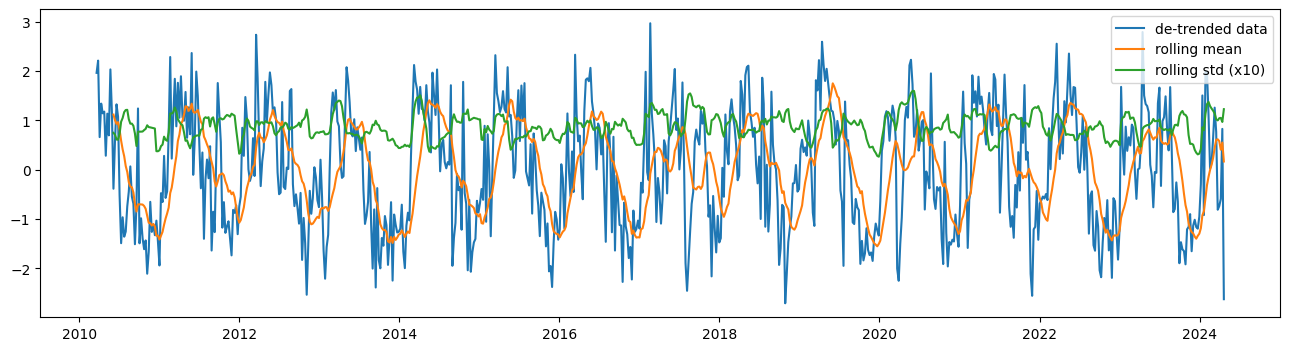

In [142]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationary(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

#### Differencing

 > Is the 12 lag differenced data stationary ?
Test statistic = -8.719
P-value = 0.000
Critical values :
	1%: -3.4395418285955563 - The data is  stationary with 99% confidence
	5%: -2.865596454500293 - The data is  stationary with 95% confidence
	10%: -2.5689301318958955 - The data is  stationary with 90% confidence


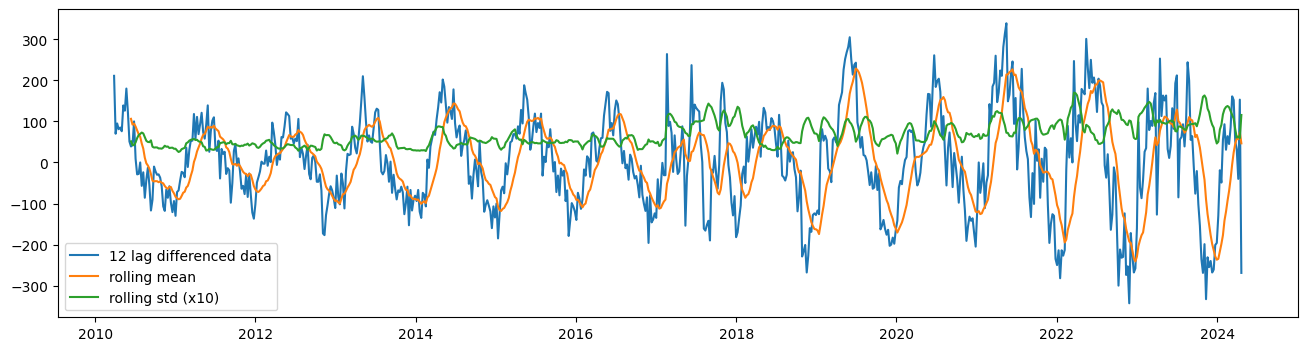

In [143]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationary(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

#### Detrending and Differencing




 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -8.011
P-value = 0.000
Critical values :
	1%: -3.4396861854831964 - The data is  stationary with 99% confidence
	5%: -2.865660062273053 - The data is  stationary with 95% confidence
	10%: -2.5689640195342456 - The data is  stationary with 90% confidence


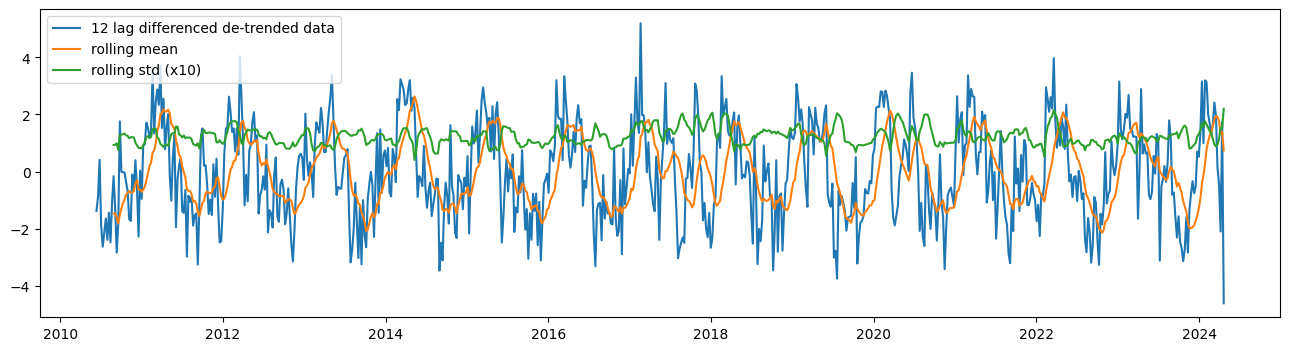

In [144]:
y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationary(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

# Implementing Different Time Series Prediction Models
https://medium.datadriveninvestor.com/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1


using exponential smoothing and SARIMA

In [157]:
y.tail(10)

created date
2024-02-18    366
2024-02-25    377
2024-03-03    417
2024-03-10    473
2024-03-17    449
2024-03-24    359
2024-03-31    368
2024-04-07    372
2024-04-14    456
2024-04-21    184
Freq: W-SUN, Name: sighting, dtype: int64

## Simple Exponential Smoothing

###T set the y_to_train, y_to_test and the lenght of predict units

In [167]:
#y_to_train = y[:'2024-03'] # dataset to train
#y_to_val = y['2024-04':] # last 4 month for test
predict_date = len(y) - len(y[:'2023-03-12']) # The number of data points for the test set

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 113.38
The Root Mean Squared Error of our forecasts with auto optimization is 113.36


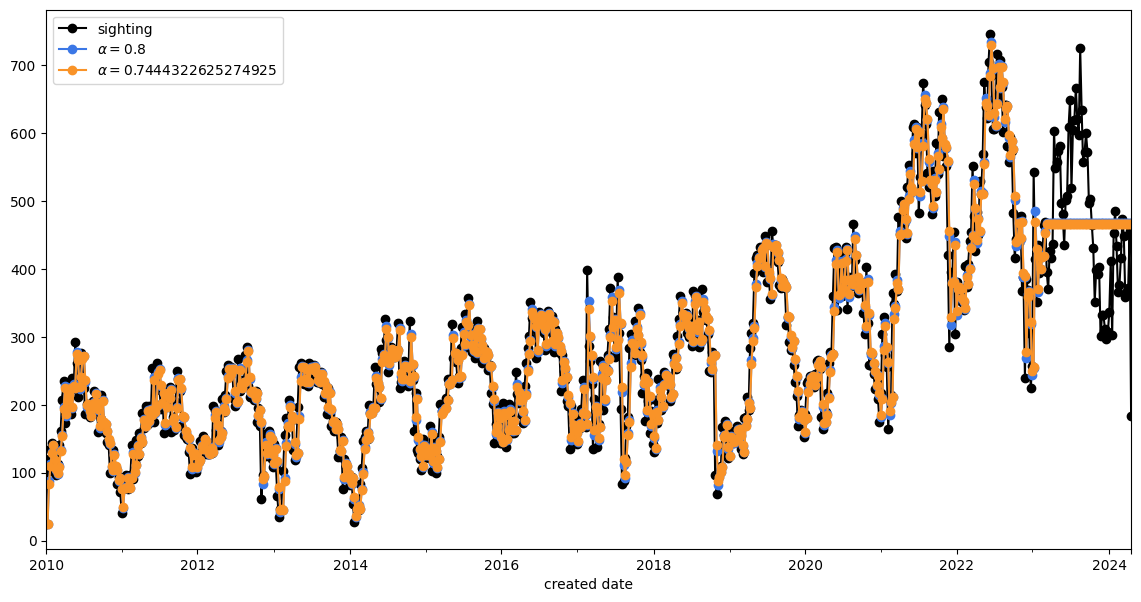

In [166]:
def ses(y, y_to_train, y_to_test, smoothing_level):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))

    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level, optimized=False)
    fcast1 = fit1.forecast(len(y_to_test))
    fcast1.index = y_to_test.index  # Aligning index for proper visualization
    fcast1.name = r'$\alpha={}$'.format(smoothing_level)
    fcast1.plot(marker='o', color='#3B77E6', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='#3B77E6')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))

    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(len(y_to_test))
    fcast2.index = y_to_test.index  # Aligning index for proper visualization
    fcast2.name = r'$\alpha=%s$' % fit2.model.params['smoothing_level']
    # plot
    fcast2.plot(marker='o', color='#F99328', legend=True)
    fit2.fittedvalues.plot(marker='o', color='#F99328')

    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))

    plt.show()

# Adjusted forecasting horizon to ensure it falls within available data
y_to_train = y[:'2023-03-05'] # dataset to train
y_to_val = y['2023-03-12':] # last 18 months for test

ses(y, y_to_train, y_to_val, 0.8)

### SARIMA
### SARIMA
Help sources: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
Additional codes can be added: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [150]:
import itertools

def sarima_grid_search(y, seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]

    mini = float('+inf')
    param_mini = None  # Initialize param_mini
    param_seasonal_mini = None  # Initialize param_seasonal_mini

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()

                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

            except:
                continue

    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))


In [153]:
sarima_grid_search(y, 52)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:6772.698580727243


#### sarima grid search results
It took 24 minutes to run. Here are the results to avoid running it again:

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:6772.698580727243

In [154]:
# Call function after pick the right (p,d,q) for SARIMA based on the AIC (akaike infomation criterion)
def sarima_eva(y, order, seasonal_order, seasonal_period, pred_date, y_to_test):
  # fit the model
  mod = sm.tsa.statespace.SARIMAX(y,
                                  order=order,
                                  seasonal_order=seasonal_order,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
  results = mod.fit()
  print(results.summary().tables[1])

  results.plot_diagnostics(figsize=(16, 8))
  plt.show()

  # the dynamic=False arguement ensures that we produce one-step ahead forecasts,
  # meaning that forecasts at each point are generated using he full history up to that point
  pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
  pred_ci = pred.conf_int()
  y_forcasted = pred.predicted_mean
  mse = ((y_forcasted - y_to_test) ** 2).mean()
  print('The Root Mean Squared Error of SARIMA with season_lenght={} and dynamic=False {}'.format(seasonal_period, round(np.sqrt(mse), 2)))

  ax = y.plot(label='observed')
  y_forcasted.plot(ax=ax, label='One-Step Ahead Forcast', alpha=0.7, figsize=(14,7))
  ax.fill_between(pred_ci.index,
                  pred_ci.iloc[:, 0],
                  pred_ci.iloc[:, 1], color='k', alpha=0.2)

  ax.set_xlabel('Date')
  ax.set_ylabel('Sessions')

  plt.legend()
  plt.show()

  # A better representation of our true predictvive power can be obtained using dynamic forecasts
  # In this case, we only use information from the time series up to a certain point,
  # and after that, forecasts are generated using values from previous forecasted time points.
  pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
  pred_dynamic_ci = pred_dynamic.conf_int()
  y_forcasted_dynamic = pred_dynamic.predicted_mean
  mse_dynamic = ((y_forcasted_dynamic - y_to_test) ** 2).mean()
  print('The Root Mean Squared Error of SARIMA with season_lenght={} and dynamic=True {}'.format(seasonal_period, round(np.sqrt(mse), 2)))

  ax = y.plot(label='observed')
  y_forcasted_dynamic.plot(ax=ax, label='Dynamic Forcast', alpha=0.7, figsize=(14,7))
  ax.fill_between(pred_dynamic_ci.index,
                  pred_dynamic_ci.iloc[:, 0],
                  pred_dynamic_ci.iloc[:, 1], color='k', alpha=0.2)

  ax.set_xlabel('Date')
  ax.set_ylabel('Sessions')

  plt.legend()
  plt.show()

  return(results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5495      0.044     12.561      0.000       0.464       0.635
ma.L1         -0.8945      0.022    -39.886      0.000      -0.938      -0.851
ma.S.L52      -0.7720      0.033    -23.618      0.000      -0.836      -0.708
sigma2      2200.6009     69.398     31.710      0.000    2064.584    2336.618


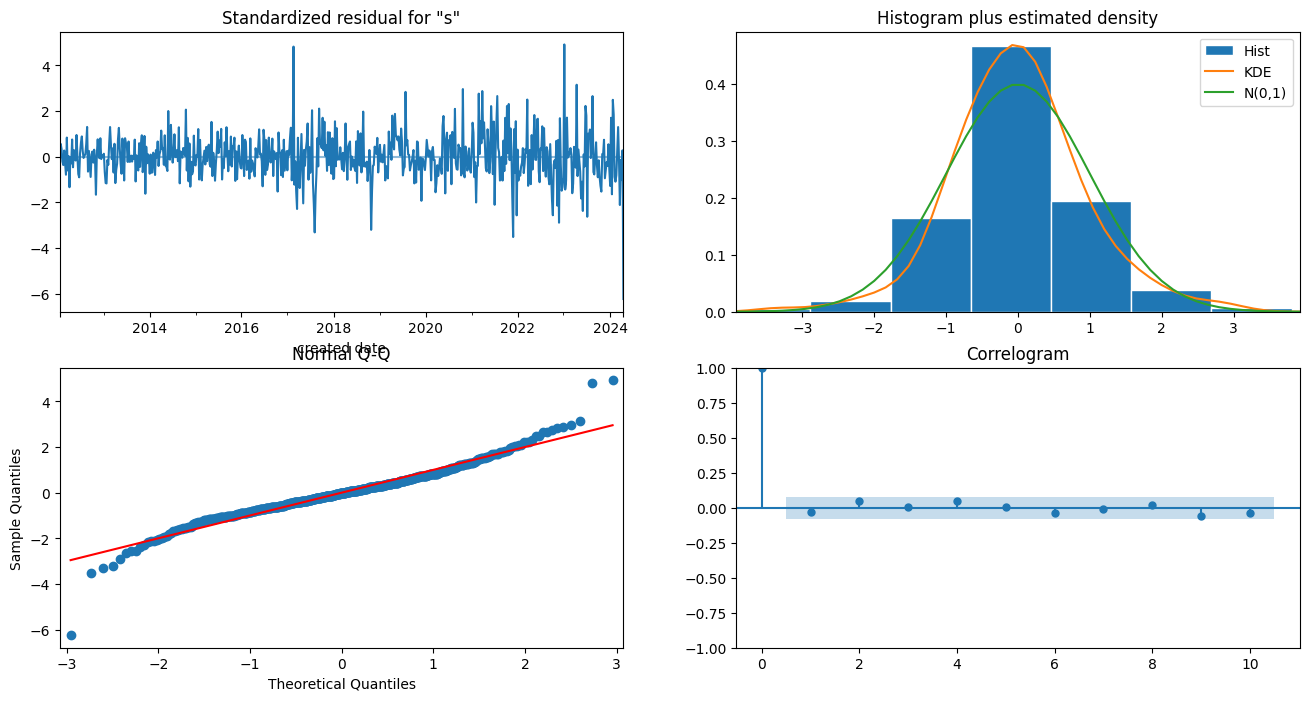

The Root Mean Squared Error of SARIMA with season_lenght=52 and dynamic=False 68.82


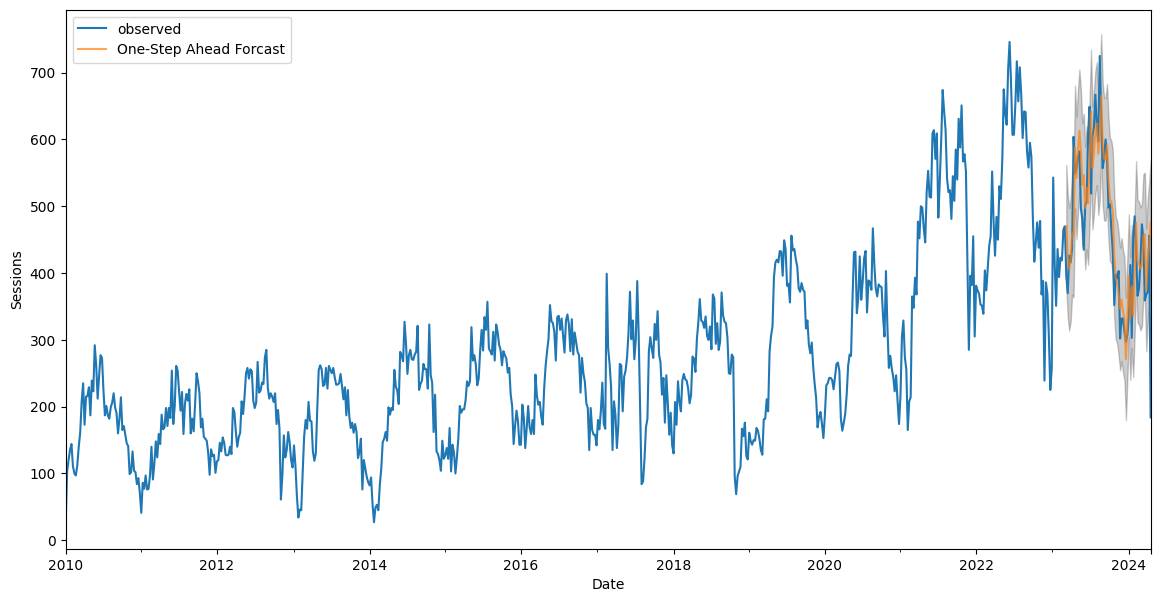

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



The Root Mean Squared Error of SARIMA with season_lenght=52 and dynamic=False 68.82


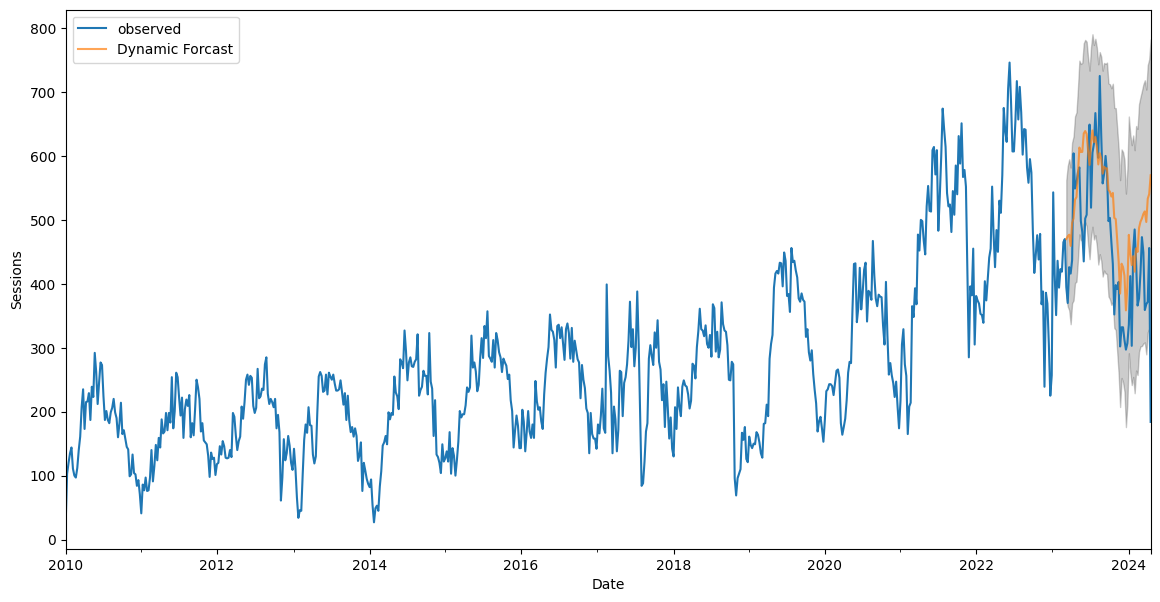

In [168]:
model = sarima_eva(y,(1, 1, 1),(0, 1, 1, 52),52,'2023-03-12', y_to_val)

In [173]:
def forecast(model, predict_steps, y):

  pred_uc = model.get_forecast(steps=predict_steps)

  #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
  pred_ci = pred_uc.conf_int()

  ax = y.plot(label='observed', figsize=(14,7))
  #print(pred_uc.predicted_mean)
  pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
  ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
  ax.set_xlabel('Date')
  ax.set_ylabel(y.name)

  plt.legend()
  plt.show()

  #Produce the forcasted tables
  pm = pred_uc.predicted_mean.reset_index()
  pm.columns = ['Date', 'Predicted_Mean']
  pci = pred_ci.reset_index()
  pci.columns = ['Date', 'Lower Bound', 'Upper Bound']
  final_table = pm.join(pci.set_index('Date'), on='Date')

  return(final_table)

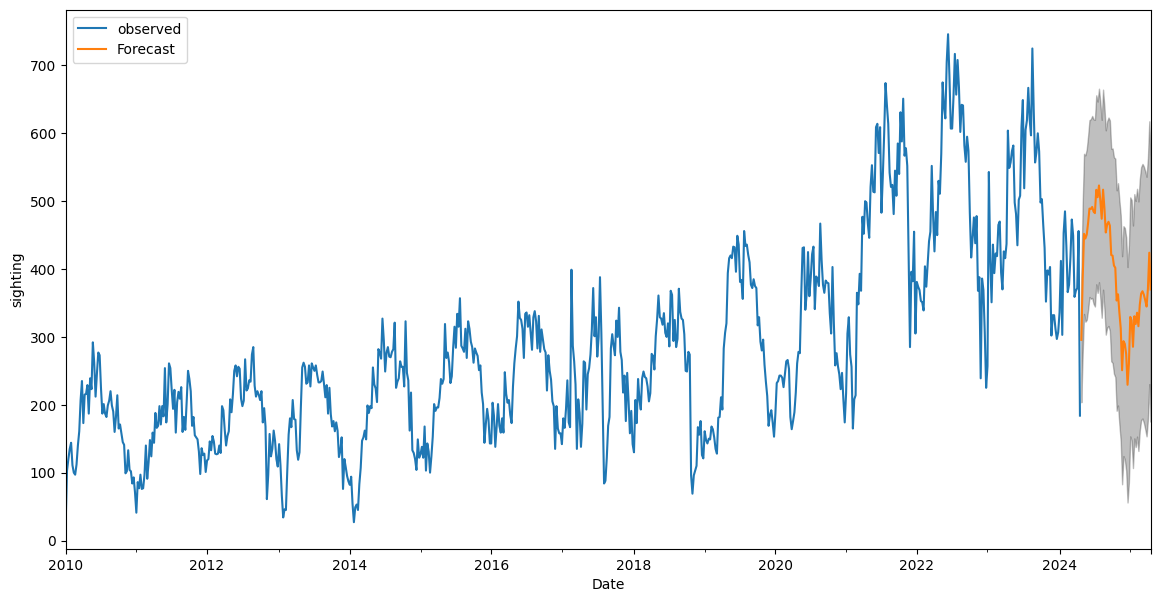

Date  Predicted_Mean  Lower Bound  Upper Bound
0 2024-04-28    295.60451459 203.64821322 387.56081595
1 2024-05-05    385.24972298 275.32196204 495.17748392
2 2024-05-12    451.82751939 333.86046689 569.79457189
3 2024-05-19    444.98870528 322.43205817 567.54535239
4 2024-05-26    450.86077021 325.15473691 576.56680351

In [174]:
final_table = forecast(model,52,y)
final_table.head()

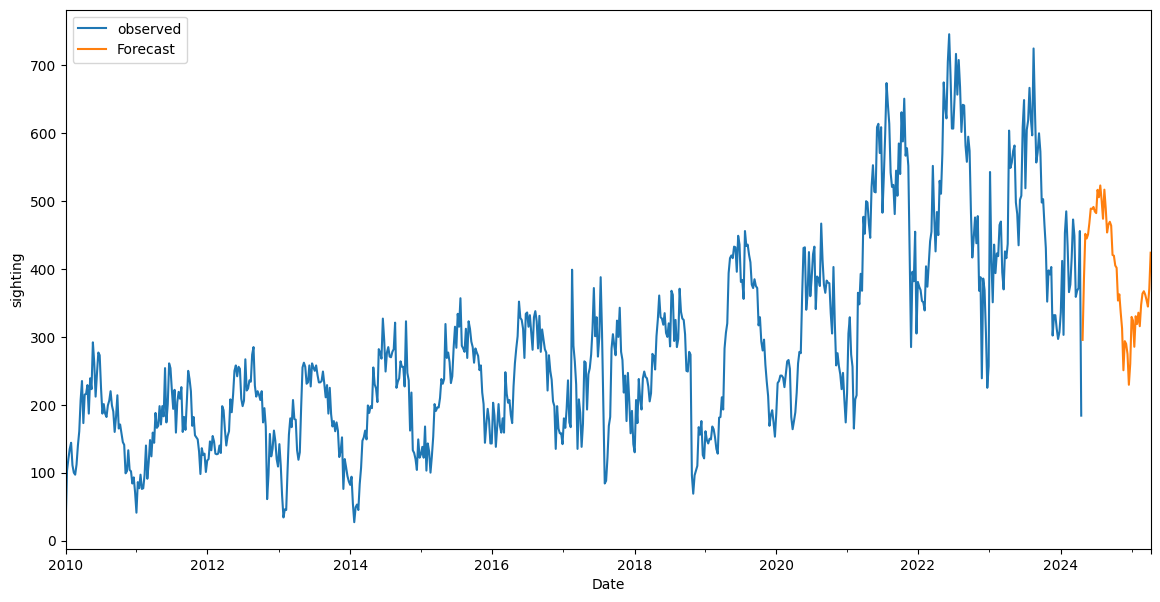

In [175]:
### Graphs without the confident interval
pred_uc = model.get_forecast(steps=51)
ax = y.plot(label='observed', figsize=(14,7))
# print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

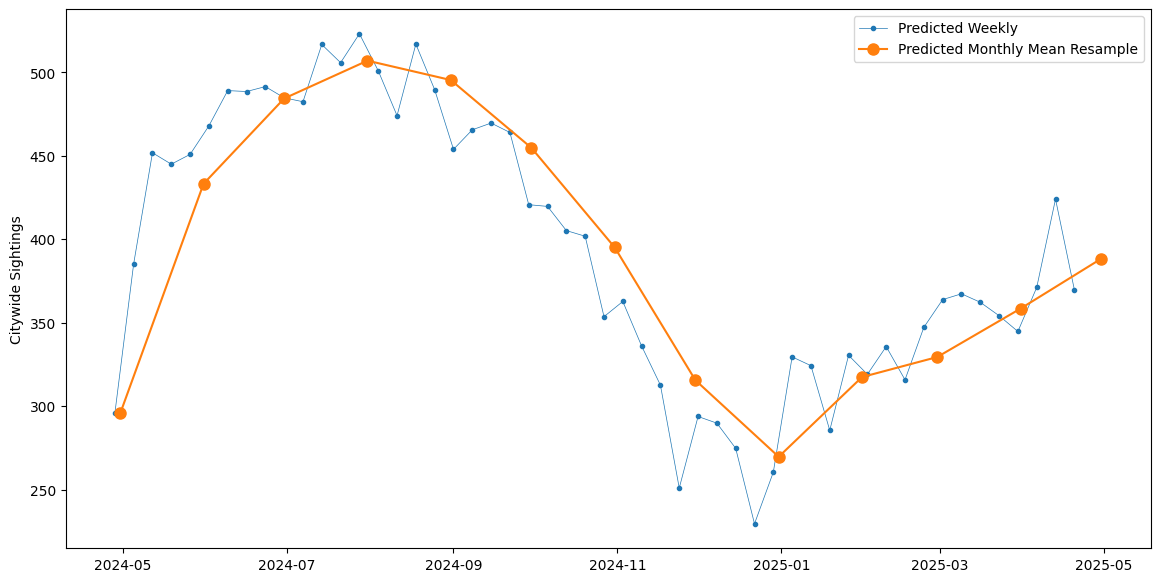

In [177]:
### Graphs show onl the predicted period
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize=(14,7))
# ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='weekly')
ax.plot(final_table.Predicted_Mean,marker='.', linestyle='-', linewidth=0.5, label='Predicted Weekly')
# ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(final_table.Predicted_Mean.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Predicted Monthly Mean Resample')
ax.set_ylabel('Citywide Sightings')
ax.legend();